In [ ]:
import pandas as pd

# Setting pandas to display max columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

# Setting pandas inf values to be nan
pd.set_option('mode.use_inf_as_na', True)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay,roc_curve, auc, f1_score
from sklearn.utils import class_weight

from yellowbrick.classifier import ROCAUC

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow.keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import keras.backend as K

import datetime

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importing dataset

df = pd.read_csv("https://raw.githubusercontent.com/Robertos4/diabetesClassification/main/diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

Diabetes_012  HighBP  HighChol  CholCheck    BMI  Smoker  Stroke  \
0         0.000   1.000     1.000      1.000 40.000   1.000   0.000   
1         0.000   0.000     0.000      0.000 25.000   1.000   0.000   
2         0.000   1.000     1.000      1.000 28.000   0.000   0.000   
3         0.000   1.000     0.000      1.000 27.000   0.000   0.000   
4         0.000   1.000     1.000      1.000 24.000   0.000   0.000   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                 0.000         0.000   0.000    1.000              0.000   
1                 0.000         1.000   0.000    0.000              0.000   
2                 0.000         0.000   1.000    0.000              0.000   
3                 0.000         1.000   1.000    1.000              0.000   
4                 0.000         1.000   1.000    1.000              0.000   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk   Sex  \
0          1.000        0.000    5.000    18.000    15.000     1.000 0.000   
1          0.000        1.000    3.000     0.000     0.000     0.000 0.000   
2          1.000        1.000    5.000    30.000    30.000     1.000 0.000   
3          1.000        0.000    2.000     0.000     0.000     0.000 0.000   
4          1.000        0.000    2.000     3.000     0.000     0.000 0.000   

     Age  Education  Income  
0  9.000      4.000   3.000  
1  7.000      6.000   1.000  
2  9.000      4.000   8.000  
3 11.000      3.000   6.000  
4 11.000      5.000   4.000

In [ ]:
# Renaming target column

df.rename(
    columns={
        "Diabetes_012": "Target"
    },
    inplace=True
)
df["Target"] = df["Target"].astype("int64")

In [ ]:
CATEGORICAL_DATA = [
    "HighBP", "HighChol", "CholCheck",
    "Smoker", "Stroke", "HeartDiseaseorAttack",
    "PhysActivity", "Fruits", "Veggies",
    "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost",
    "GenHlth", "DiffWalk", "Sex",
    "Age", "Education", "Income"
]

NUMERICAL_DATA = [
    "BMI", "MentHlth", "PhysHlth",
]

CATEGORICAL_ORDINAL_DATA = [
    "GenHlth", "Age", "Education", "Income"
]

CATEGORICAL_NOMINAL_DATA = [
    "HighBP", "HighChol", "CholCheck",
    "Smoker", "Stroke", "HeartDiseaseorAttack",
    "PhysActivity", "Fruits", "Veggies",
    "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost",
    "DiffWalk", "Sex"
]

# About dataset, metrics and goals

## Dataset

1. The dataset was taken from https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset;
2. The dataset has 253,680 rows and



# Data analysis & data cleaning

Data analysis has been done in this chapter in the code below, as well as by using library sweetviz, which generates automatic exploratory data analysis.

In [ ]:
# description of dataset

df[NUMERICAL_DATA].describe()

BMI   MentHlth   PhysHlth
count 253680.000 253680.000 253680.000
mean      28.382      3.185      4.242
std        6.609      7.413      8.718
min       12.000      0.000      0.000
25%       24.000      0.000      0.000
50%       27.000      0.000      0.000
75%       31.000      2.000      3.000
max       98.000     30.000     30.000

## Checking missing data

- There is no missing data in the dataset;
- The reason for it is that the dataset was already cleaned by author, and by close inspection of the notebook, I am certain that missing data was dropped and cleaned;

In [ ]:
df.isna().any().any()

False

## Checking duplicates

- There are 11,187 rows that are present more than 1 time;
- From that there are:
    - 7,219 rows that are present 2 times;
    - 3,968 rows that are present more than 2 times;
- In order to not have bias in the dataset, I dropped only rows, that were present in the dataset more than 2 times (3,968).

In [ ]:
# Checking if there are any duplicates

df.duplicated().any()

True

In [ ]:
# How many are there duplicates only

len(df.loc[df.duplicated() == True])

23899

In [ ]:
# Grouping rows that are the same

dupli = df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'records'})
dupli.loc[dupli["records"] > 1]

Target  HighBP  HighChol  CholCheck    BMI  Smoker  Stroke  \
33           0   0.000     0.000      0.000 17.000   0.000   0.000   
78           0   0.000     0.000      0.000 18.000   0.000   0.000   
172          0   0.000     0.000      0.000 19.000   0.000   0.000   
174          0   0.000     0.000      0.000 19.000   0.000   0.000   
200          0   0.000     0.000      0.000 19.000   0.000   0.000   
...        ...     ...       ...        ...    ...     ...     ...   
225467       2   1.000     1.000      1.000 37.000   0.000   0.000   
226166       2   1.000     1.000      1.000 38.000   0.000   0.000   
226392       2   1.000     1.000      1.000 38.000   1.000   0.000   
226448       2   1.000     1.000      1.000 38.000   1.000   0.000   
226727       2   1.000     1.000      1.000 39.000   0.000   0.000   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  \
33                     0.000         1.000   1.000    1.000   
78                     0.000         1.000   1.000    1.000   
172                    0.000         1.000   1.000    1.000   
174                    0.000         1.000   1.000    1.000   
200                    0.000         1.000   1.000    1.000   
...                      ...           ...     ...      ...   
225467                 0.000         1.000   0.000    1.000   
226166                 0.000         1.000   1.000    1.000   
226392                 0.000         1.000   0.000    1.000   
226448                 0.000         1.000   1.000    1.000   
226727                 0.000         1.000   1.000    1.000   

        HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  \
33                  0.000          1.000        0.000    1.000     0.000   
78                  0.000          1.000        0.000    1.000     0.000   
172                 0.000          1.000        0.000    1.000     0.000   
174                 0.000          1.000        0.000    1.000     0.000   
200                 0.000          1.000        0.000    2.000     0.000   
...                   ...            ...          ...      ...       ...   
225467              0.000          1.000        0.000    3.000     0.000   
226166              0.000          1.000        0.000    3.000     0.000   
226392              0.000          1.000        0.000    3.000     0.000   
226448              0.000          1.000        0.000    3.000     0.000   
226727              0.000          1.000        0.000    2.000     0.000   

        PhysHlth  DiffWalk   Sex    Age  Education  Income  records  
33         0.000     0.000 0.000  8.000      6.000   8.000        2  
78         0.000     0.000 0.000 10.000      6.000   8.000        2  
172        0.000     0.000 0.000  4.000      6.000   8.000        3  
174        0.000     0.000 0.000  6.000      6.000   8.000        2  
200        0.000     0.000 0.000  9.000      6.000   8.000        2  
...          ...       ...   ...    ...        ...     ...      ...  
225467     0.000     0.000 1.000 10.000      6.000   8.000        2  
226166     1.000     0.000 1.000  7.000      6.000   8.000        2  
226392     0.000     0.000 1.000 11.000      6.000   6.000        2  
226448     0.000     0.000 1.000 10.000      5.000   8.000        2  
226727     0.000     0.000 1.000  9.000      6.000   8.000        2  

[11187 rows x 23 columns]

In [ ]:
# Checking how many rows are:

# - Present only 1 time;
print(len(dupli.loc[dupli["records"] == 1]))

# - Present more than 1 time;
print(len(dupli.loc[dupli["records"] > 1]))

# - Present only 2 times;
print(len(dupli.loc[dupli["records"] == 2]))

# - Present more than 2 times;
print(len(dupli.loc[dupli["records"] > 2]))

218594
11187
7219
3968


In [ ]:
len(dupli)

229781

In [ ]:
# Dropping duplicates present more than 2 times

dupli = dupli.loc[dupli["records"] <= 2]

len(dupli)

225813

In [ ]:
# Concatenating grouped rows with duplicates

pres2 = dupli.loc[dupli["records"] == 2]
df = pd.concat([dupli, pres2], ignore_index=True)

len(df)
df.head()

Target  HighBP  HighChol  CholCheck    BMI  Smoker  Stroke  \
0       0   0.000     0.000      0.000 14.000   1.000   0.000   
1       0   0.000     0.000      0.000 15.000   0.000   0.000   
2       0   0.000     0.000      0.000 15.000   1.000   0.000   
3       0   0.000     0.000      0.000 15.000   1.000   0.000   
4       0   0.000     0.000      0.000 16.000   0.000   0.000   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                 0.000         1.000   1.000    1.000              0.000   
1                 0.000         0.000   1.000    0.000              0.000   
2                 0.000         0.000   0.000    0.000              0.000   
3                 1.000         0.000   1.000    1.000              0.000   
4                 0.000         0.000   0.000    0.000              0.000   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk   Sex  \
0          1.000        0.000    3.000     4.000     4.000     0.000 1.000   
1          0.000        0.000    1.000     0.000     0.000     0.000 0.000   
2          1.000        0.000    5.000    20.000    28.000     1.000 0.000   
3          0.000        1.000    3.000     0.000    29.000     0.000 0.000   
4          1.000        0.000    2.000     0.000     0.000     0.000 0.000   

     Age  Education  Income  records  
0 11.000      6.000   8.000        1  
1  1.000      5.000   7.000        1  
2 10.000      6.000   4.000        1  
3  7.000      5.000   2.000        1  
4 11.000      5.000   5.000        1

In [ ]:
df.drop(axis=1, labels="records", inplace=True)
df.head()

Target  HighBP  HighChol  CholCheck    BMI  Smoker  Stroke  \
0       0   0.000     0.000      0.000 14.000   1.000   0.000   
1       0   0.000     0.000      0.000 15.000   0.000   0.000   
2       0   0.000     0.000      0.000 15.000   1.000   0.000   
3       0   0.000     0.000      0.000 15.000   1.000   0.000   
4       0   0.000     0.000      0.000 16.000   0.000   0.000   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                 0.000         1.000   1.000    1.000              0.000   
1                 0.000         0.000   1.000    0.000              0.000   
2                 0.000         0.000   0.000    0.000              0.000   
3                 1.000         0.000   1.000    1.000              0.000   
4                 0.000         0.000   0.000    0.000              0.000   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk   Sex  \
0          1.000        0.000    3.000     4.000     4.000     0.000 1.000   
1          0.000        0.000    1.000     0.000     0.000     0.000 0.000   
2          1.000        0.000    5.000    20.000    28.000     1.000 0.000   
3          0.000        1.000    3.000     0.000    29.000     0.000 0.000   
4          1.000        0.000    2.000     0.000     0.000     0.000 0.000   

     Age  Education  Income  
0 11.000      6.000   8.000  
1  1.000      5.000   7.000  
2 10.000      6.000   4.000  
3  7.000      5.000   2.000  
4 11.000      5.000   5.000

## Distributions

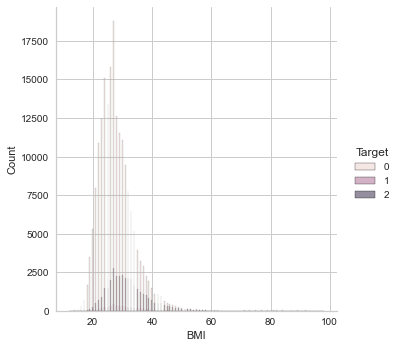

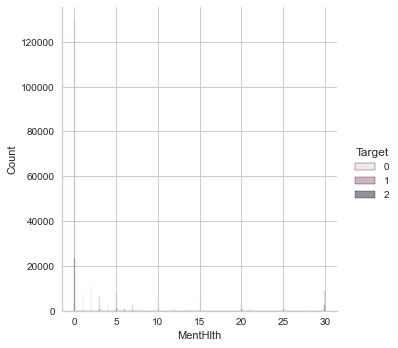

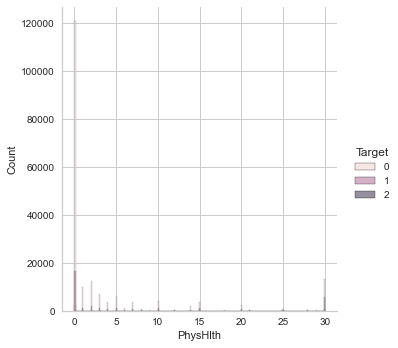

In [ ]:
for i in NUMERICAL_DATA:
    sns.displot(df, x=i, hue="Target")

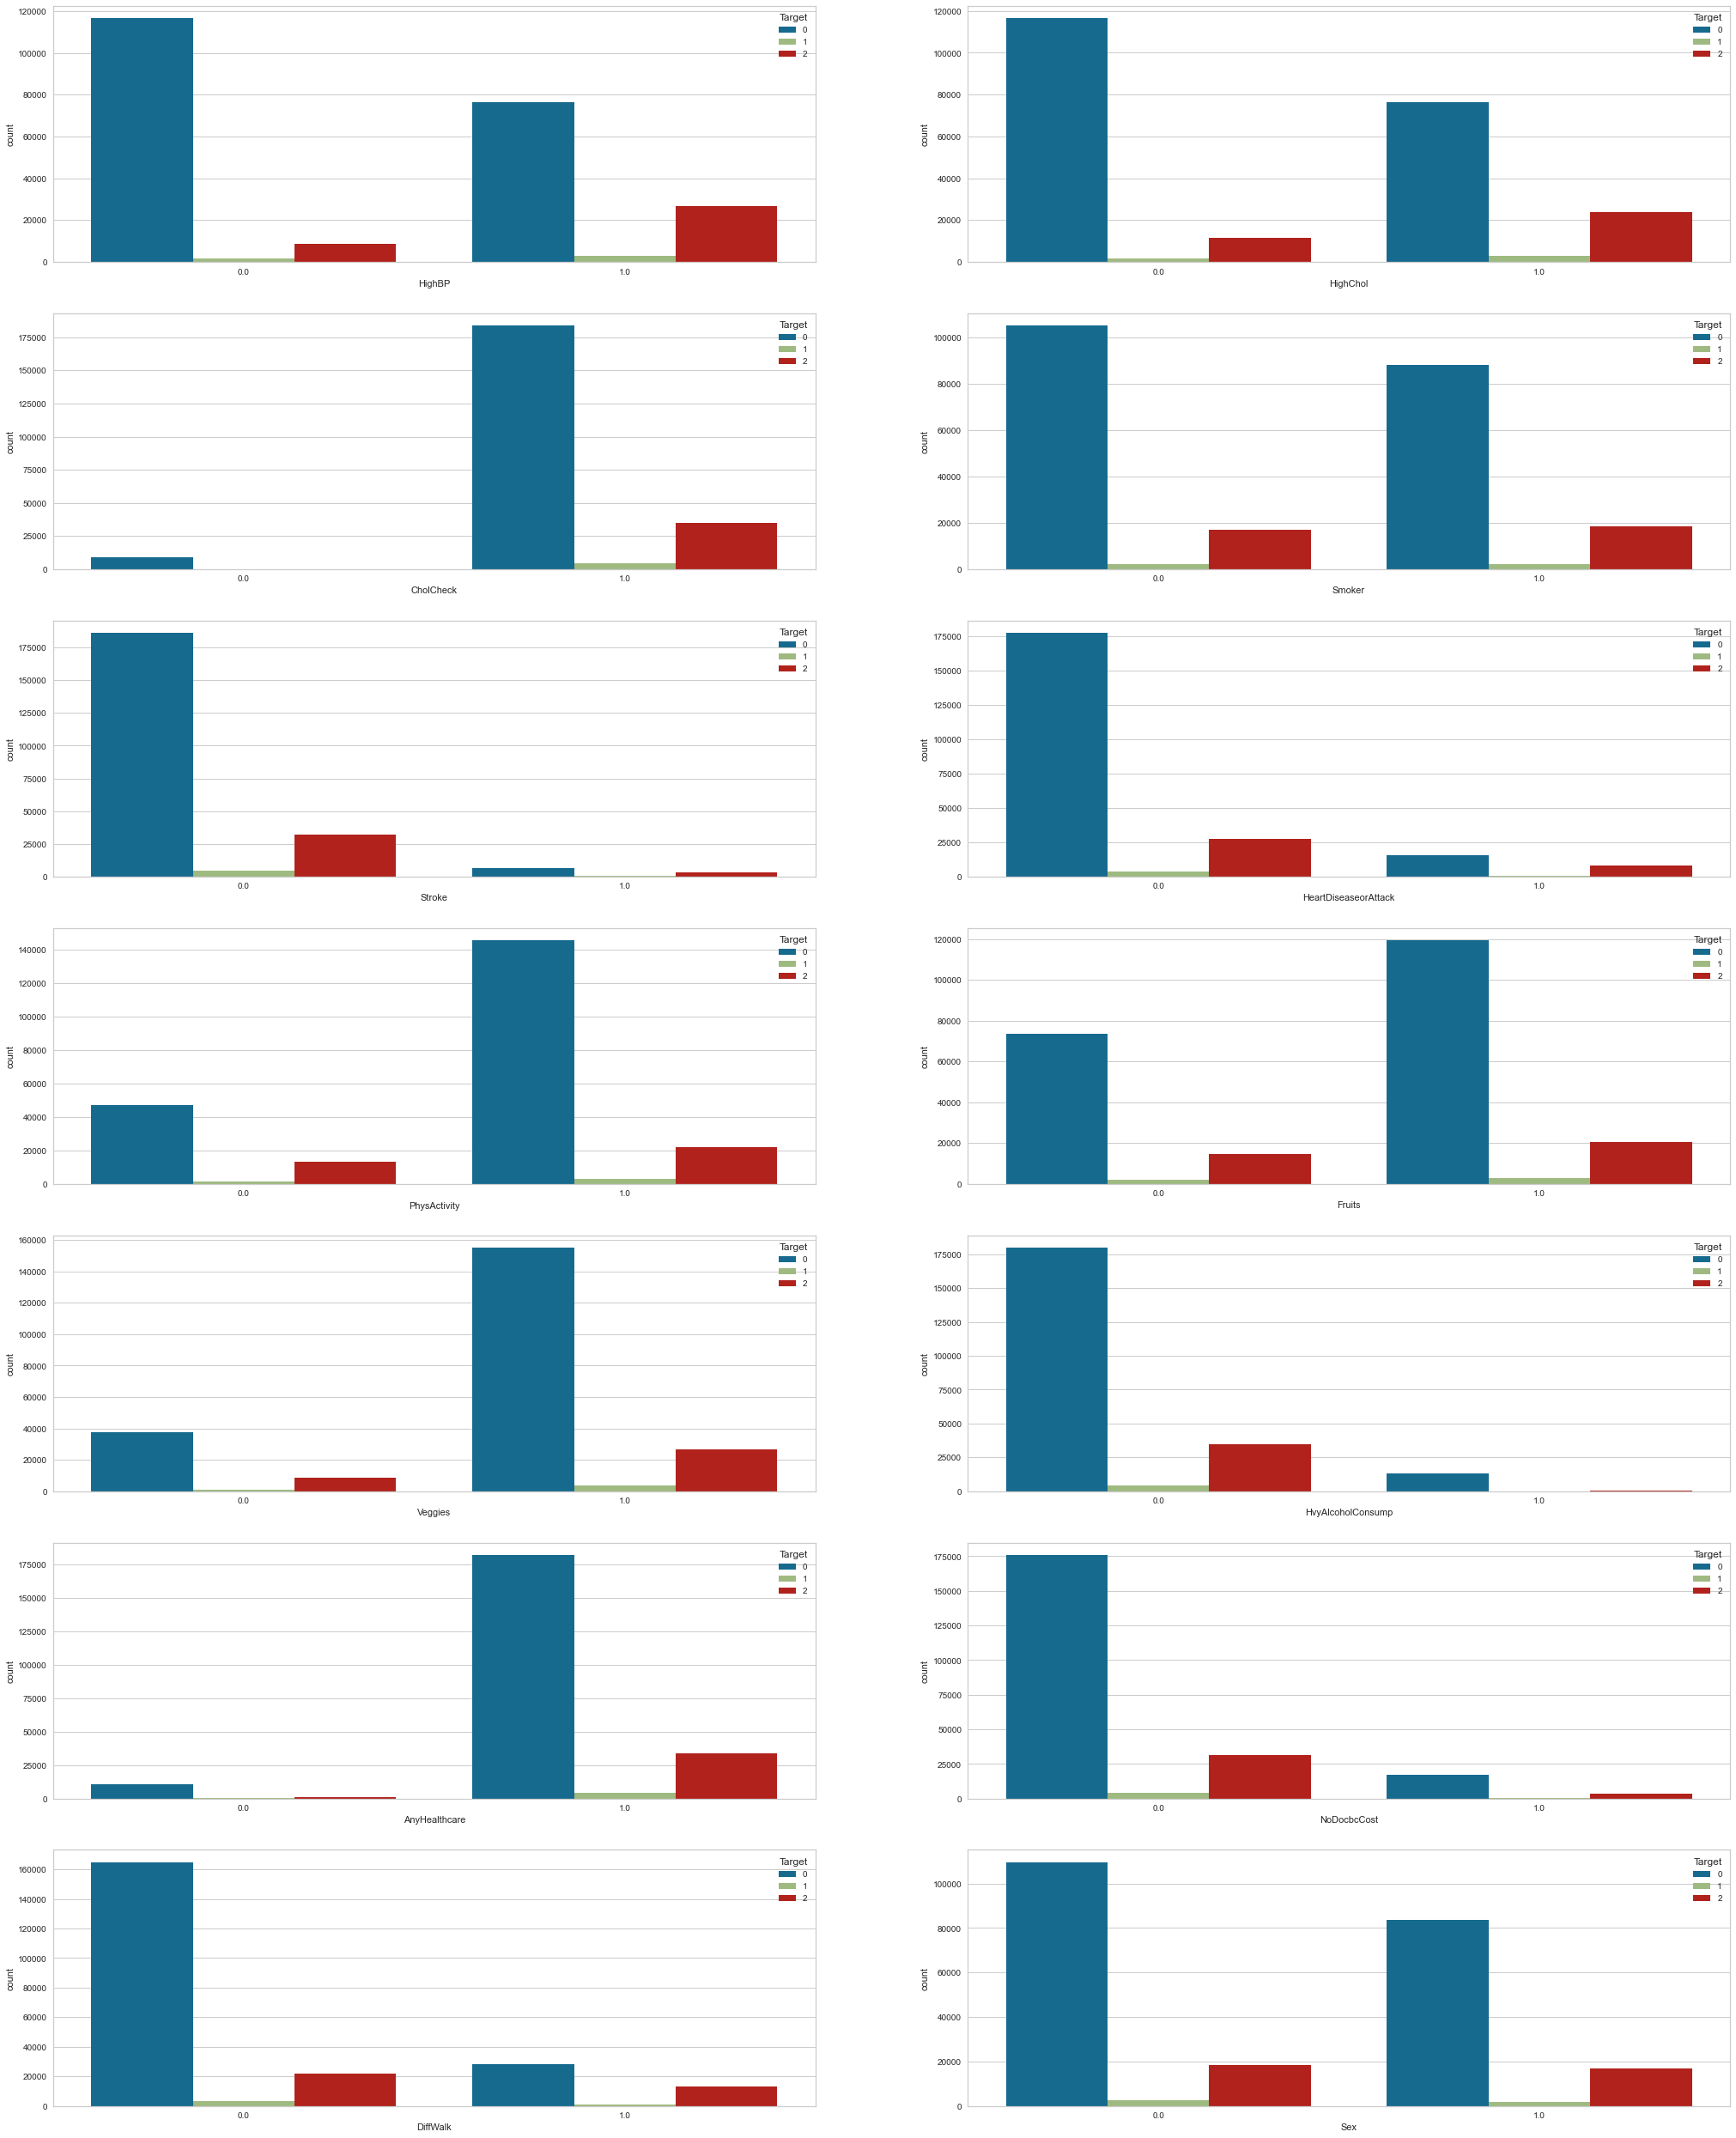

In [ ]:
fig, axes = plt.subplots(7, 2, figsize=(35,45))
for cat, ax in zip(CATEGORICAL_NOMINAL_DATA, axes.flatten()):
    sns.countplot(cat, data=df, hue="Target", ax=ax)

## Correlation

<AxesSubplot:>

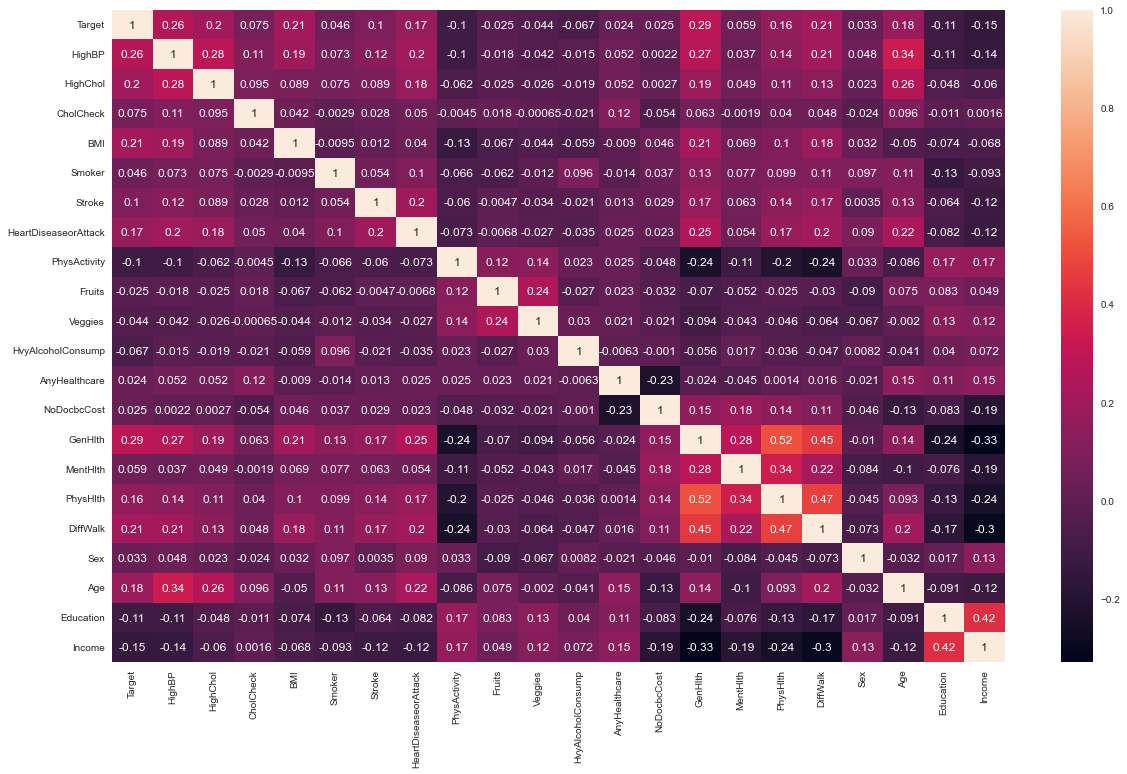

In [ ]:
#Heatmap of correlation
plt.figure(figsize = (20,12))
sns.heatmap(df.corr(), annot=True)

## Count plot of target variable

<AxesSubplot:xlabel='Target', ylabel='count'>

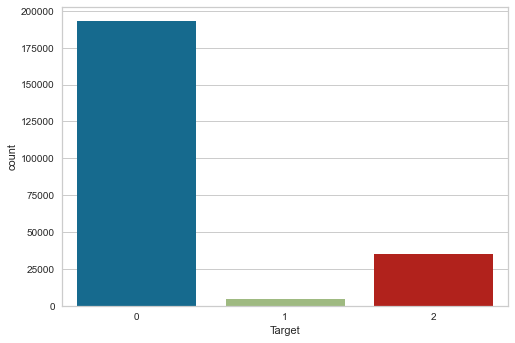

In [ ]:
sns.countplot(df['Target'])

## Train test split

In [ ]:
# Split Target col from rest

X, y = df.iloc[:, 1:], df.iloc[:, 0]
X.drop(["MentHlth", "PhysHlth"], axis=1, inplace=True)

y = LabelEncoder().fit_transform(y)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=123, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.7, random_state=123, stratify=y_test)

In [ ]:
std = StandardScaler()
# X_train[["BMI"]]
X_train[["BMI"]] = std.fit_transform(X_train[["BMI"]])
X_test[["BMI"]] = std.transform(X_test[["BMI"]])
X_val[["BMI"]] = std.transform(X_val[["BMI"]])

In [ ]:
over = BorderlineSMOTE(sampling_strategy={0: 48276, 1: 19419, 2: 19419})
under = RandomUnderSampler(sampling_strategy={0: 19419, 1: 19419, 2: 19419})

X_train, y_train = over.fit_resample(X_train, y_train)
X_train, y_train = under.fit_resample(X_train, y_train)

# Functions

In [ ]:
# Plotting function

def train_plot(x_sns, y_sns, hue_sns, col_sns, result_df):
    sns.relplot(
        data = result_df,
        kind = 'line',
        x = x_sns,
        y = y_sns,
        hue = hue_sns,
        col = col_sns
    )
    plt.show()

In [ ]:
# Model grid search and plotting it function

def train(model, params, plot_param, hue):
    parameters = params
    parameters["random_state"] = [123]

    grid = GridSearchCV(
        model,
        parameters,
        scoring=[
            "balanced_accuracy", "f1_weighted",
            "precision_weighted", "recall_weighted",
            "roc_auc_ovr_weighted"
        ],
        error_score='raise',
        cv=2,
        verbose=1,
        refit="f1_weighted"
    ).fit(X_train, y_train)

    print('Training score: ' + str(f1_score(y_train, grid.predict(X_train), average='weighted')))
    print('Test score: ' + str(f1_score(y_test, grid.predict(X_test), average='weighted')))

    # Access the best set of parameters
    best_params = grid.best_params_
    print(best_params)
    # Stores the optimum model in best_pipe
    best_est = grid.best_estimator_
    print(best_est)

    result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')
    # print(result_df.columns)

    train_plot(plot_param, "mean_test_balanced_accuracy", hue, None, result_df)
    train_plot(plot_param, "mean_test_f1_weighted", hue, None, result_df)
    train_plot(plot_param, "mean_test_precision_weighted", hue, None, result_df)
    train_plot(plot_param, "mean_test_recall_weighted", hue, None, result_df)
    train_plot(plot_param, "mean_test_roc_auc_ovr_weighted", hue, None, result_df)

    return result_df

# Random forest classification

## Default random forest

In [ ]:
default_random_model = RandomForestClassifier(
    random_state=123,
)

default_random = default_random_model.fit(X_train, y_train)
print('Training score: ' + str(f1_score(y_train, default_random.predict(X_train), average='weighted')))
print('Test score: ' + str(f1_score(y_test, default_random.predict(X_test), average='weighted')))

Training score: 0.9972885552307675
Test score: 0.7774343763738676


## Hypertuning random forest

### Hypertuning n_estimators

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Training score: 0.9971511777352424
Test score: 0.7777226253864459
{'max_features': 'auto', 'n_estimators': 181, 'random_state': 123}
RandomForestClassifier(max_features='auto', n_estimators=181, random_state=123)


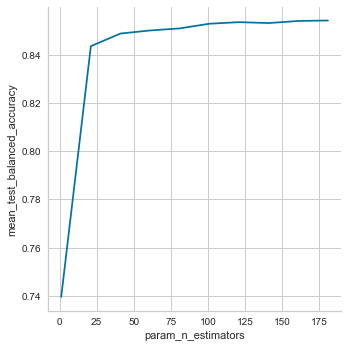

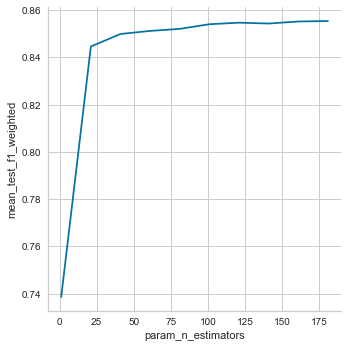

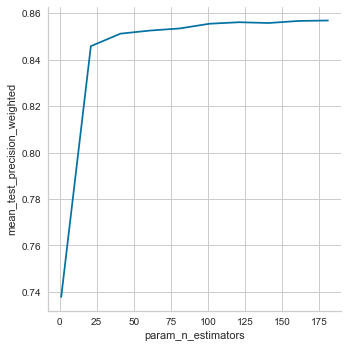

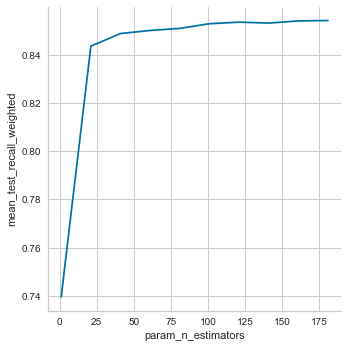

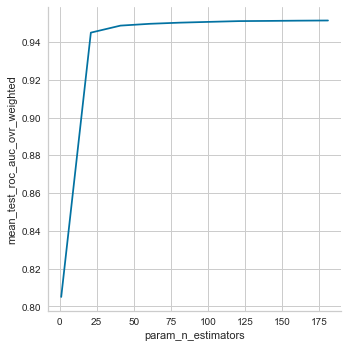

In [ ]:
res = train(
    RandomForestClassifier(),
    {
 	# 'max_depth': [i for i in range(1, 20, 1)],
 	'max_features': ['auto'],
 	# 'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64],
 	# 'min_samples_split': [2, 5, 10, 20, 40, 80],
    'n_estimators': [i for i in range(1, 200, 20)],
    # 'class_weight': ["balanced"]
    },
    "param_n_estimators",
    None
)

From all scores, the bigger the n_estimators value, the better performance. However, to not overfit the model, I will stick with default 100 for now.

### Hypertuning min_samples_split

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Training score: 0.9971511027216113
Test score: 0.7765878799144035
{'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123}
RandomForestClassifier(max_features='auto', random_state=123)


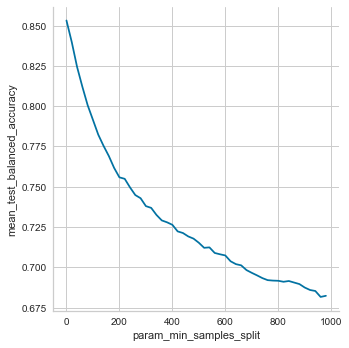

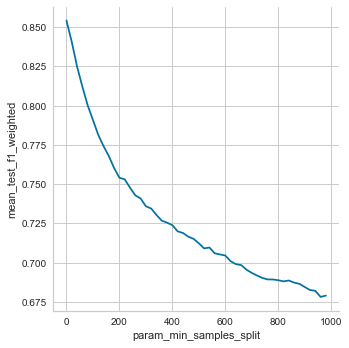

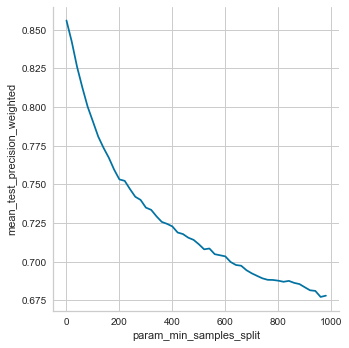

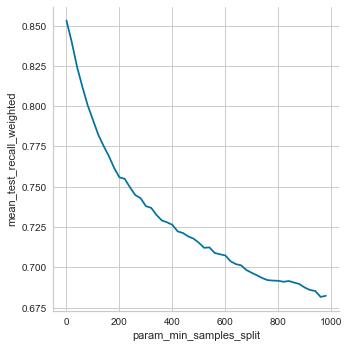

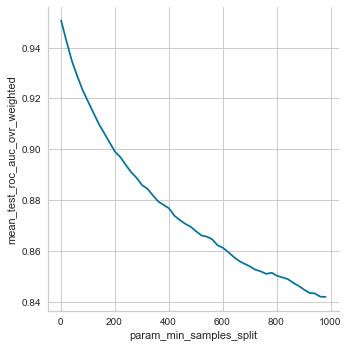

In [ ]:
res = train(
    RandomForestClassifier(),
    {
 	# 'max_depth': [i for i in range(1, 20, 1)],
 	'max_features': ['auto'],
 	# 'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64],
 	'min_samples_split': [i for i in range(2, 1001, 20)],
    'n_estimators': [100],
    # 'class_weight': ["balanced"]
    },
    'param_min_samples_split',
    None
)

2 is the best min_samples_split.

### Hypertuning min_samples_leaf

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Training score: 0.9971511027216113
Test score: 0.7765878799144035
{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123}
RandomForestClassifier(max_features='auto', random_state=123)


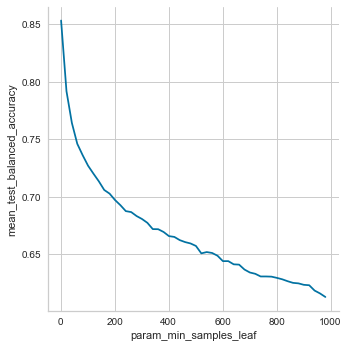

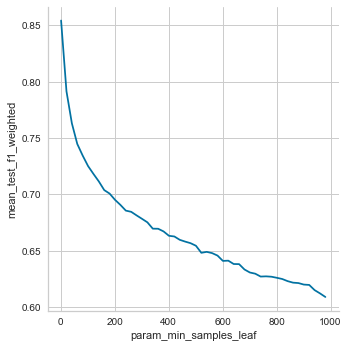

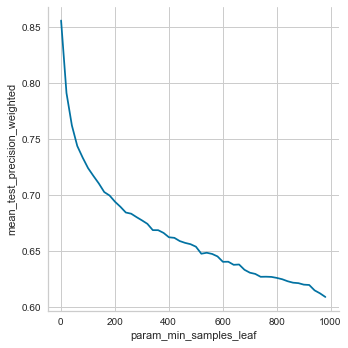

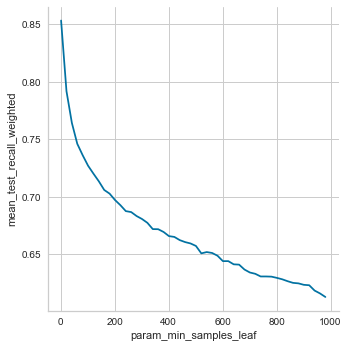

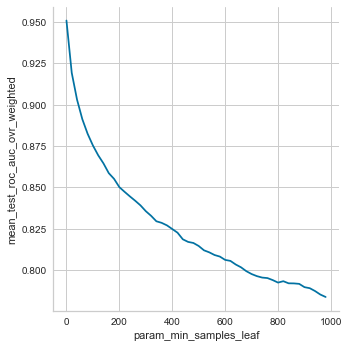

In [ ]:
res = train(
    RandomForestClassifier(),
    {
 	# 'max_depth': [i for i in range(1, 20, 1)],
 	'max_features': ['auto'],
 	'min_samples_leaf': [i for i in range(1, 1001, 20)],
 	'min_samples_split': [2],
    'n_estimators': [100],
    # 'class_weight': ["balanced"]
    },
    'param_min_samples_leaf',
    None
)

1 is the best min_samples_leaf.

### Hypertuning max_depth

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Training score: 0.997254160052612
Test score: 0.7785973452032582
{'max_depth': 31, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123}
RandomForestClassifier(max_depth=31, max_features='auto', random_state=123)


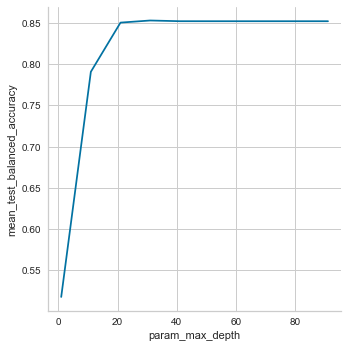

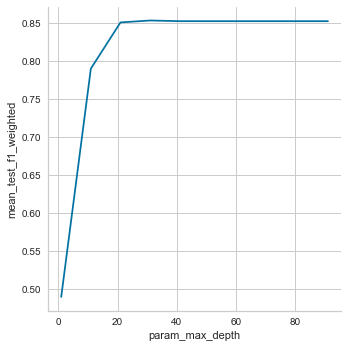

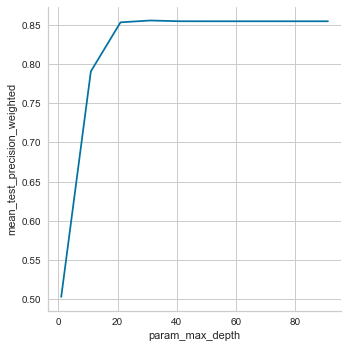

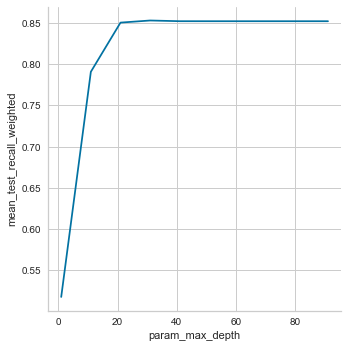

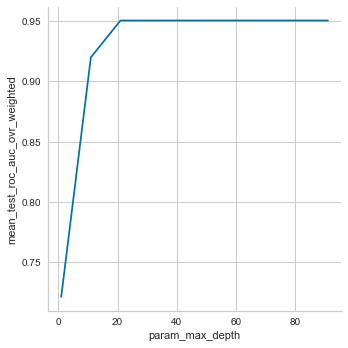

In [ ]:
res = train(
    RandomForestClassifier(),
    {
 	'max_depth': [i for i in range(1, 100, 10)],
 	'max_features': ['auto'],
 	'min_samples_leaf': [1],
 	'min_samples_split': [2],
    'n_estimators': [100],
    # 'class_weight': ["balanced"]
    },
    'param_max_depth',
    None
)

Max depth slows down performance at 20, but I will go with 40.

### Hypertuning max_features

Fitting 2 folds for each of 19 candidates, totalling 38 fits
Training score: 0.9972886094702529
Test score: 0.7792385045063173
{'max_depth': 40, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123}
RandomForestClassifier(max_depth=40, max_features=2, random_state=123)


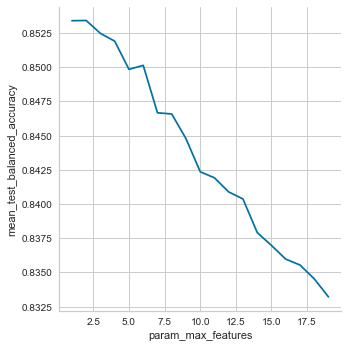

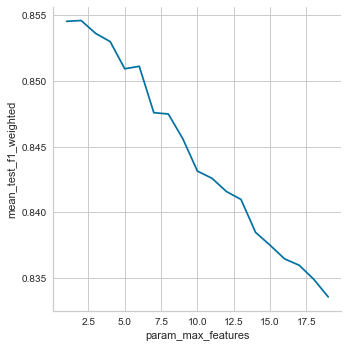

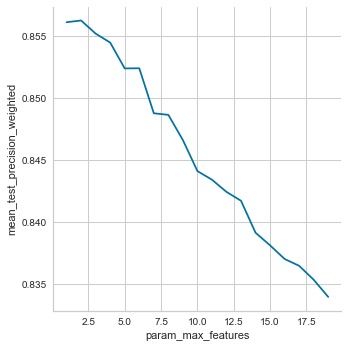

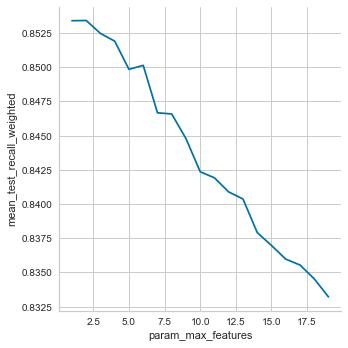

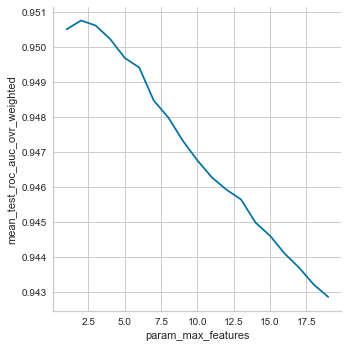

In [ ]:
res = train(
    RandomForestClassifier(),
    {
 	'max_depth': [40],
 	'max_features': [i for i in range(1, 20, 1)],
 	'min_samples_leaf': [1],
 	'min_samples_split': [2],
    'n_estimators': [100],
    # 'class_weight': ["balanced"]
    },
    'param_max_features',
    None
)

The best param for max_features is 2, but I will go with 6 with almost no performance loss.

## Comparing default with hypertuned random forest

In [ ]:
# Final hypertuned random forest model

tuned_random_model = RandomForestClassifier(
    random_state=123,
    max_depth=40,
    max_features=6,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100
)

tuned_random = tuned_random_model.fit(X_train, y_train)
print('Training score: ' + str(f1_score(y_train, tuned_random.predict(X_train), average='weighted')))
print('Test score: ' + str(f1_score(y_test, tuned_random.predict(X_test), average='weighted')))

Training score: 0.9972887437290813
Test score: 0.7755653479229475


Comparing default random forest with hypertuned.
Default random forest
Training set score: 0.9972885552307675
Test set score: 0.7790219954880675


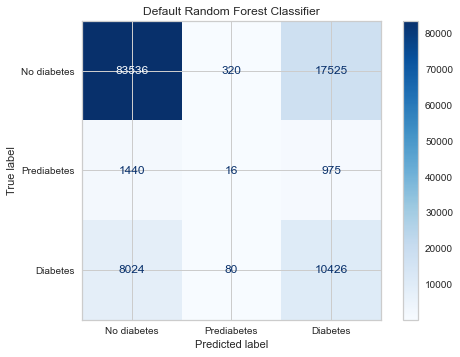

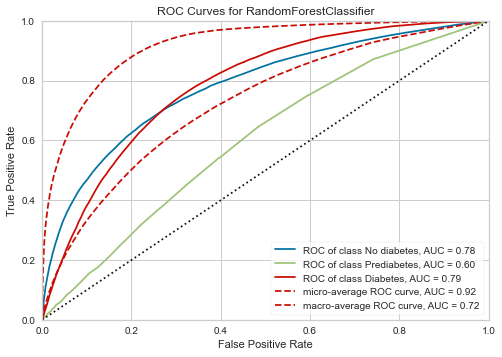

Hypertuned random forest
Training set score: 0.9972887437290813
Test set score: 0.7781314841509751


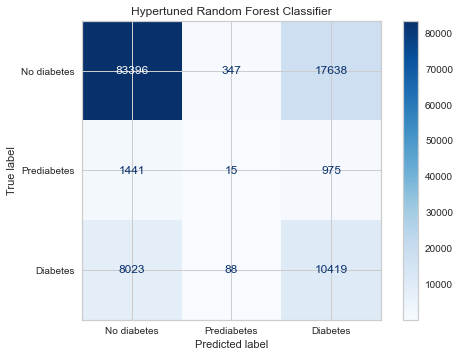

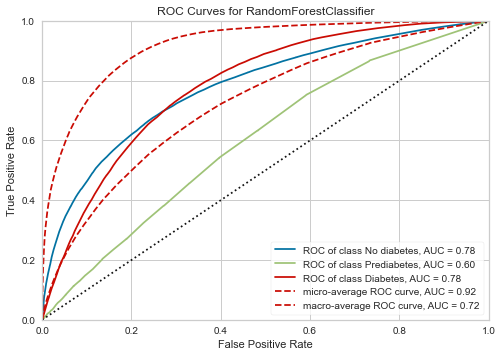

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
print("Comparing default random forest with hypertuned.")

print("Default random forest")

print('Training set score: ' + str(f1_score(y_train, default_random.predict(X_train), average='weighted')))

print('Test set score: ' + str(f1_score(y_val, default_random.predict(X_val), average='weighted')))

disp = ConfusionMatrixDisplay.from_estimator(
    default_random,
    X_val,
    y_val,
    display_labels=["No diabetes", "Prediabetes", "Diabetes"],
    cmap=plt.cm.Blues,
    normalize=None,
    values_format = '.5g'
)
disp.ax_.set_title("Default Random Forest Classifier")

plt.show()

visualizer = ROCAUC(default_random_model, classes=["No diabetes", "Prediabetes", "Diabetes"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()

######################################################

print("Hypertuned random forest")

print('Training set score: ' + str(f1_score(y_train, tuned_random.predict(X_train), average='weighted')))

print('Test set score: ' + str(f1_score(y_val, tuned_random.predict(X_val), average='weighted')))


disp = ConfusionMatrixDisplay.from_estimator(
    tuned_random,
    X_val,
    y_val,
    display_labels=["No diabetes", "Prediabetes", "Diabetes"],
    cmap=plt.cm.Blues,
    normalize=None,
    values_format = '.5g'
)
disp.ax_.set_title("Hypertuned Random Forest Classifier")

plt.show()

visualizer = ROCAUC(tuned_random_model, classes=["No diabetes", "Prediabetes", "Diabetes"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()

# Logistic Regression

In [ ]:
default_logic_model = LogisticRegression(
    random_state = 123,
    multi_class = 'multinomial',
    n_jobs = -1,
)

default_logic = default_logic_model.fit(X_train, y_train)
print('Training score: ' + str(f1_score(y_train, default_logic.predict(X_train), average='weighted')))
print('Test score: ' + str(f1_score(y_test, default_logic.predict(X_test), average='weighted')))

Training score: 0.538146106150258
Test score: 0.7114165625564718


## Hypertuning C

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Training score: 0.5360058527189135
Test score: 0.710816706801139
{'C': 0.5, 'multi_class': 'multinomial', 'n_jobs': -1, 'random_state': 123}
LogisticRegression(C=0.5, multi_class='multinomial', n_jobs=-1,
                   random_state=123)


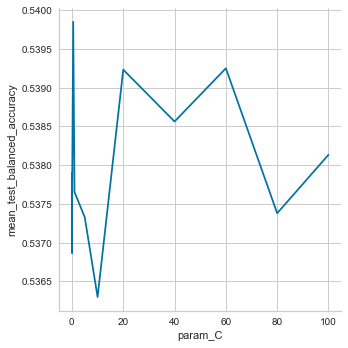

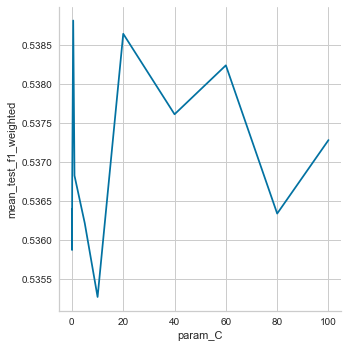

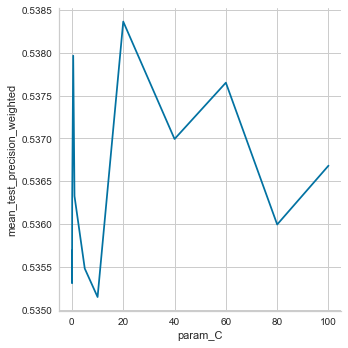

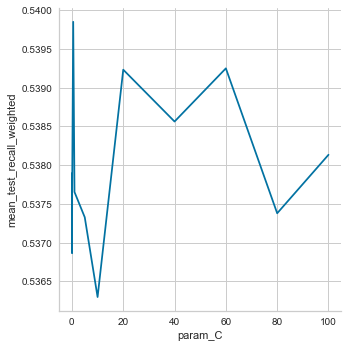

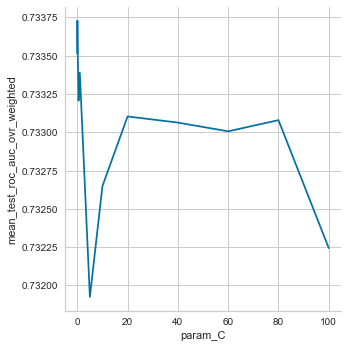

In [ ]:
res = train(
    LogisticRegression(),
    {
    "C": [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 60, 80, 100],
    "multi_class": ['multinomial'],
    "n_jobs": [-1]
    },
    "param_C",
    None
)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Training score: 0.5360058527189135
Test score: 0.710816706801139
{'C': 0.5, 'multi_class': 'multinomial', 'n_jobs': -1, 'random_state': 123}
LogisticRegression(C=0.5, multi_class='multinomial', n_jobs=-1,
                   random_state=123)


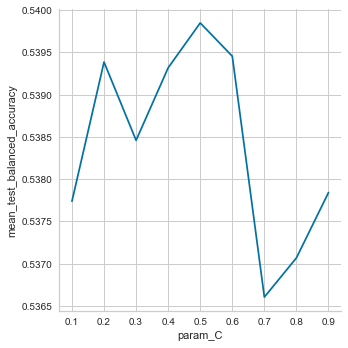

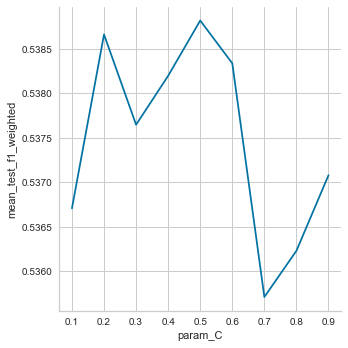

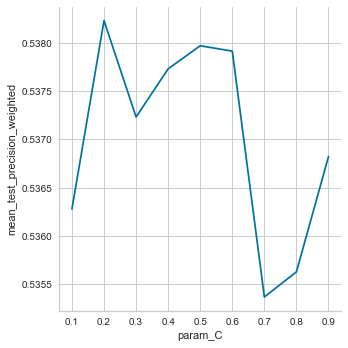

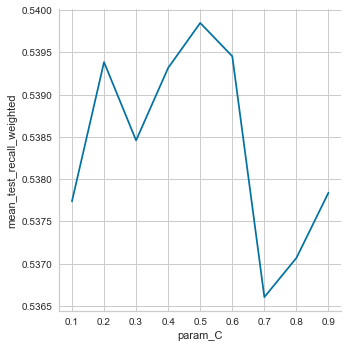

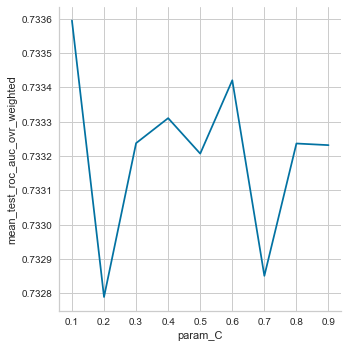

In [ ]:
res = train(
    LogisticRegression(),
    {
    "C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "multi_class": ['multinomial'],
    "n_jobs": [-1]
    },
    "param_C",
    None
)

0.5 is the best value for C parameter.

## Comparing default with hypertuned logical regression

In [ ]:
tuned_logic_model = LogisticRegression(
    random_state=123,
    multi_class = 'multinomial',
    n_jobs = -1,
    C = 0.5
)

tuned_logic = tuned_logic_model.fit(X_train, y_train)
print('Training score: ' + str(f1_score(y_train, tuned_logic.predict(X_train), average='weighted')))
print('Test score: ' + str(f1_score(y_test, tuned_logic.predict(X_test), average='weighted')))

Training score: 0.5360058527189135
Test score: 0.710816706801139


Comparing default logistic regressions with hypertuned.
Default logistic regression
Training set score: 0.538146106150258
Test set score: 0.7101604241458342


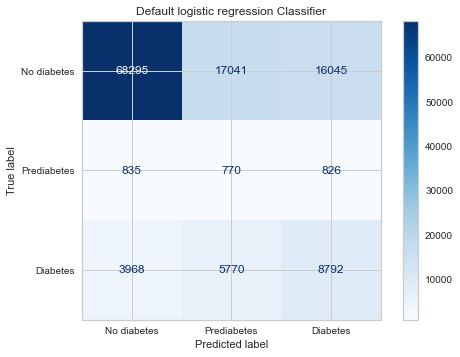

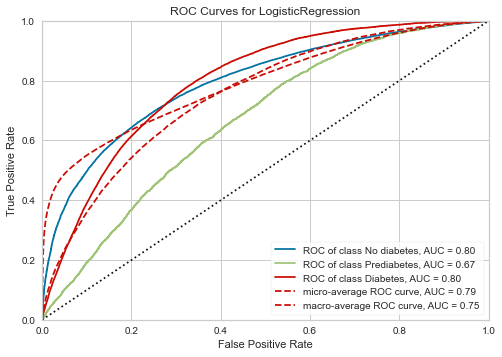

Hypertuned logistic regression
Training set score: 0.5360058527189135
Test set score: 0.711226109594805


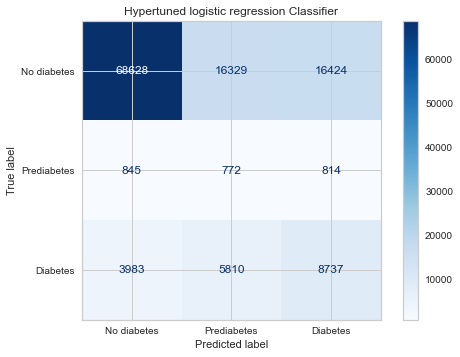

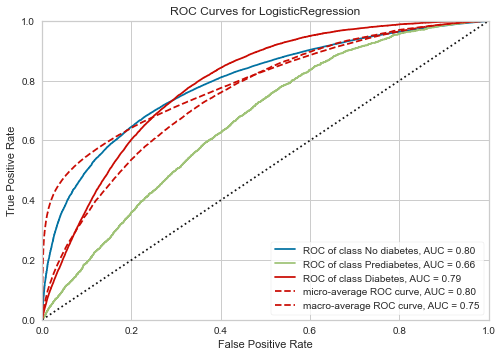

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
print("Comparing default logistic regressions with hypertuned.")

print("Default logistic regression")

print('Training set score: ' + str(f1_score(y_train, default_logic.predict(X_train), average='weighted')))

print('Test set score: ' + str(f1_score(y_val, default_logic.predict(X_val), average='weighted')))

disp = ConfusionMatrixDisplay.from_estimator(
    default_logic,
    X_val,
    y_val,
    display_labels=["No diabetes", "Prediabetes", "Diabetes"],
    cmap=plt.cm.Blues,
    normalize=None,
    values_format = '.5g'
)
disp.ax_.set_title("Default logistic regression Classifier")

plt.show()

visualizer = ROCAUC(default_logic_model, classes=["No diabetes", "Prediabetes", "Diabetes"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()

######################################################

print("Hypertuned logistic regression")

print('Training set score: ' + str(f1_score(y_train, tuned_logic.predict(X_train), average='weighted')))

print('Test set score: ' + str(f1_score(y_val, tuned_logic.predict(X_val), average='weighted')))


disp = ConfusionMatrixDisplay.from_estimator(
    tuned_logic,
    X_val,
    y_val,
    display_labels=["No diabetes", "Prediabetes", "Diabetes"],
    cmap=plt.cm.Blues,
    normalize=None,
    values_format = '.5g'
)
disp.ax_.set_title("Hypertuned logistic regression Classifier")

plt.show()

visualizer = ROCAUC(tuned_logic_model, classes=["No diabetes", "Prediabetes", "Diabetes"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()

# Neural Networks

## Train test split

In [ ]:
# Split Target col from rest and drop 2 cols

X, y = df.iloc[:, 1:], df.iloc[:, 0]
X.drop(["MentHlth", "PhysHlth"], axis=1, inplace=True)

In [ ]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=123, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.7, random_state=123, stratify=y_test)

In [ ]:
# Standardization

std = StandardScaler()

X_train[["BMI"]] = std.fit_transform(X_train[["BMI"]])
X_test[["BMI"]] = std.transform(X_test[["BMI"]])
X_val[["BMI"]] = std.transform(X_val[["BMI"]])

In [ ]:
# Under/Oversampling

over = BorderlineSMOTE(sampling_strategy={0: 48276, 1: 19419, 2: 19419})
under = RandomUnderSampler(sampling_strategy={0: 19419, 1: 19419, 2: 19419})

X_train, y_train = over.fit_resample(X_train, y_train)
X_train, y_train = under.fit_resample(X_train, y_train)

In [ ]:
# Dummy encoding

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
y_test = np_utils.to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_val)
encoded_Y = encoder.transform(y_val)
y_val = np_utils.to_categorical(encoded_Y)

## Functions

In [ ]:
# Early stopping function

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='f1_weighted',
    verbose=3,
    patience=30,
    mode='max',
    restore_best_weights=True)

In [ ]:
# One of loss functions

def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        # y_true = tf.cast(tf.convert_to_tensor(y_true, dtype = tf.float32), dtype = tf.float32)
        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
# Other loss functions

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
# Other loss functions

def f1_weighted_loss(true, pred):

    true = tf.cast(true, dtype = tf.float32)
    pred = tf.cast(pred, dtype = tf.float32)

    ground_positives = K.sum(true, axis=0) + K.epsilon()
    pred_positives = K.sum(pred, axis=0) + K.epsilon()
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()

    precision = true_positives / pred_positives
    recall = true_positives / ground_positives


    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)

    return 1 - weighted_f1

In [ ]:
# F1_weighted score

def f1_weighted(true, pred):

    predLabels = K.argmax(pred, axis=-1)
    pred = K.one_hot(predLabels, 3)

    true = tf.cast(true, dtype = tf.float32)
    pred = tf.cast(pred, dtype = tf.float32)

    ground_positives = K.sum(true, axis=0) + K.epsilon()
    pred_positives = K.sum(pred, axis=0) + K.epsilon()
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()

    precision = true_positives / pred_positives
    recall = true_positives / ground_positives

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)


    return 1 - weighted_f1

In [ ]:
# Model/tuning model function

def model_tune(unit1, unit2, epochs, v_batch, batch, label, alpha, gamma, weight, title, n_hidden):

	print(title)

	# create model
	model = Sequential()
	model.add(Dense(unit1, input_dim=19, kernel_regularizer=regularizers.l2(0.001), activation='leaky_relu'))
	if n_hidden == 2:
		model.add(Dense(unit2, input_dim=unit1, kernel_regularizer=regularizers.l2(0.001), activation='leaky_relu'))
	model.add(Dense(3, activation='softmax'))

	# Compile model
	opt = tf.keras.optimizers.Adam()
	# model.compile(loss=focal_loss(alpha=alpha,  gamma=gamma), optimizer=opt, metrics=["accuracy", "f1"])
	model.compile(loss=f1_weighted_loss, optimizer=opt, metrics=["accuracy", f1_weighted])

	# Fit model
	history = model.fit(
		X_train, y_train,
		validation_data=(X_test, y_test),
		epochs=epochs, verbose=0,
		# class_weight=weights,
		validation_batch_size=v_batch,
		batch_size=batch,
		callbacks=[early_stopping],
		use_multiprocessing=True,
		# class_weight=weight,
	)

	# Plot results
	fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(30, 8))

	# F1 score plot
	ax[0].plot(
		history.history['f1_weighted'],
		label=label + " train",
		linestyle="dashed",)
	ax[0].plot(history.history['val_f1_weighted'], label=label + " test")
	ax[0].set_title(f"{title} (F1 score)", pad=-50)
	ax[0].legend()

	# Accuracy score
	ax[1].plot(
        history.history['accuracy'],
		label=label + " train",
		linestyle="dashed",)
	ax[1].plot(history.history['val_accuracy'], label=label + " test")
	ax[1].set_title(f"{title} (Accuracy score)", pad=-50)
	ax[1].legend()

	# Loss score
	ax[2].plot(
        history.history['loss'],
		label=label + " train",
		linestyle="dashed",)
	ax[2].plot(history.history['val_loss'], label=label + " test")
	ax[2].set_title(f"{title} (Loss score)", pad=-50)
	ax[2].legend()

	# Roc curve
	y_pred = model.predict(X_test)

	fpr, tpr, thresh, n_class = {}, {}, {}, 3

	for i in range(n_class):
		fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), pos_label=i)

	# plotting
	ax[3].plot(fpr[0], tpr[0], linestyle='--',color='orange', label='No diabetes vs Rest')
	ax[3].plot(fpr[1], tpr[1], linestyle='--',color='green', label='Prediabetes vs Rest')
	ax[3].plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Diabetes vs Rest')
	ax[3].set_title(f'{title} ROC curve')
	ax[3].set_xlabel('False Positive Rate')
	ax[3].set_ylabel('True Positive rate')
	ax[3].legend(loc='best')

	# Confusion matrix
	conf_mat = tf.math.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
	sns.heatmap(conf_mat, annot=True, fmt='d', cmap = plt.cm.Blues,
			xticklabels=["No diabetes", "Prediabetes", "Diabetes"], yticklabels=["No diabetes", "Prediabetes", "Diabetes"])
	ax[4].set_ylabel('Actual')
	ax[4].set_xlabel('Predicted')

	plt.show()

	return model

## Default

Default model


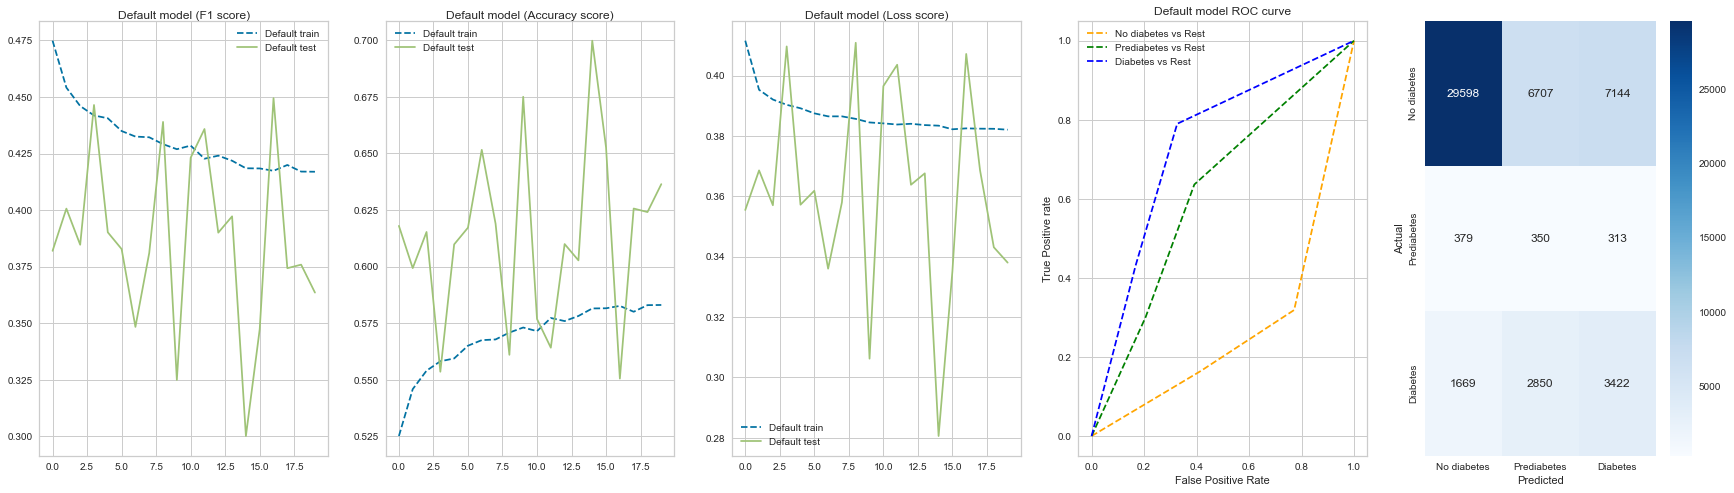

In [ ]:
default_nn = model_tune(
    unit1=38,
    unit2=20,
    epochs=20,
    v_batch=1,
    batch=1,
    gamma=2,
    alpha=1,
    label=f"Default",
    title=f"Default model",
    weight = None,
    n_hidden=2
)

## Hidden layer/s sizes hypertuning

1st_layer_size: 20 | 2nd_layer_size: 20 tuned model


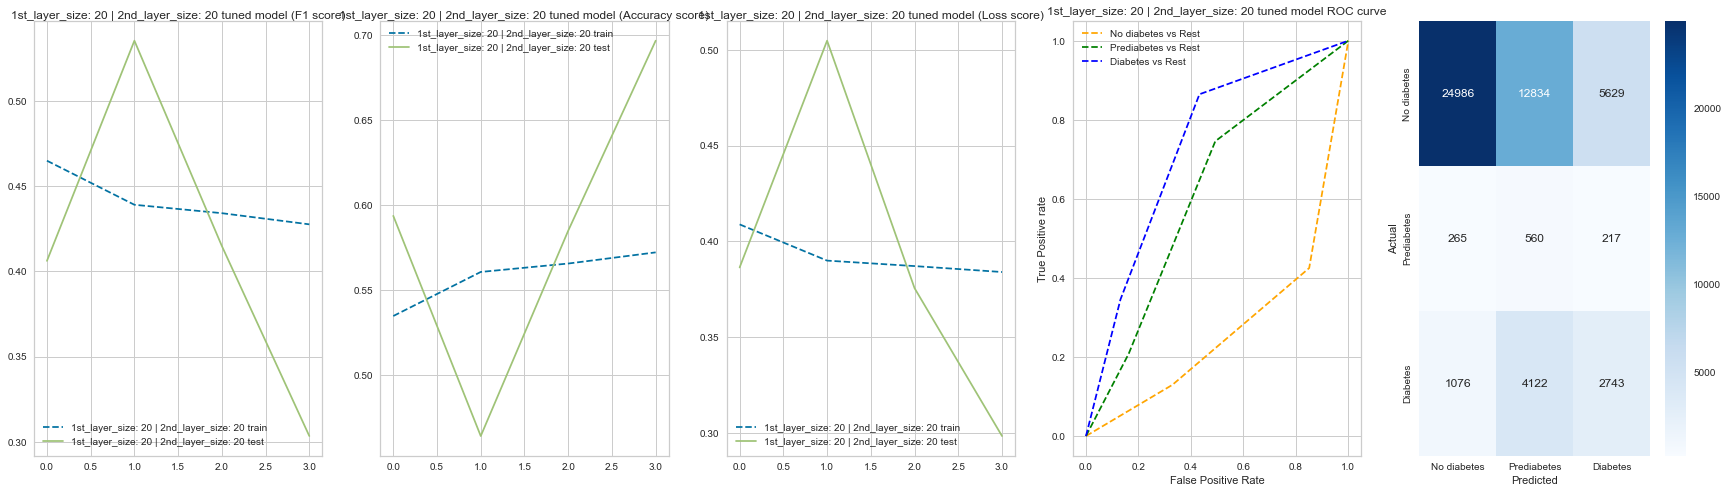

1st_layer_size: 20 | 2nd_layer_size: 40 tuned model


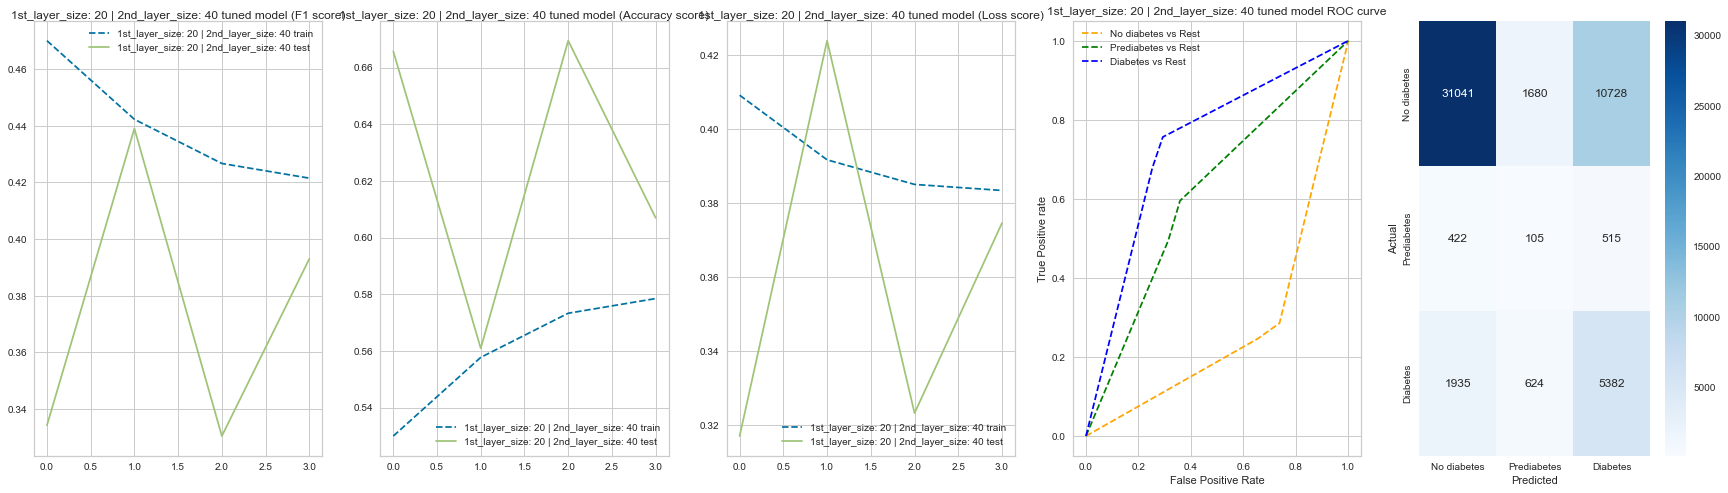

1st_layer_size: 20 | 2nd_layer_size: 60 tuned model


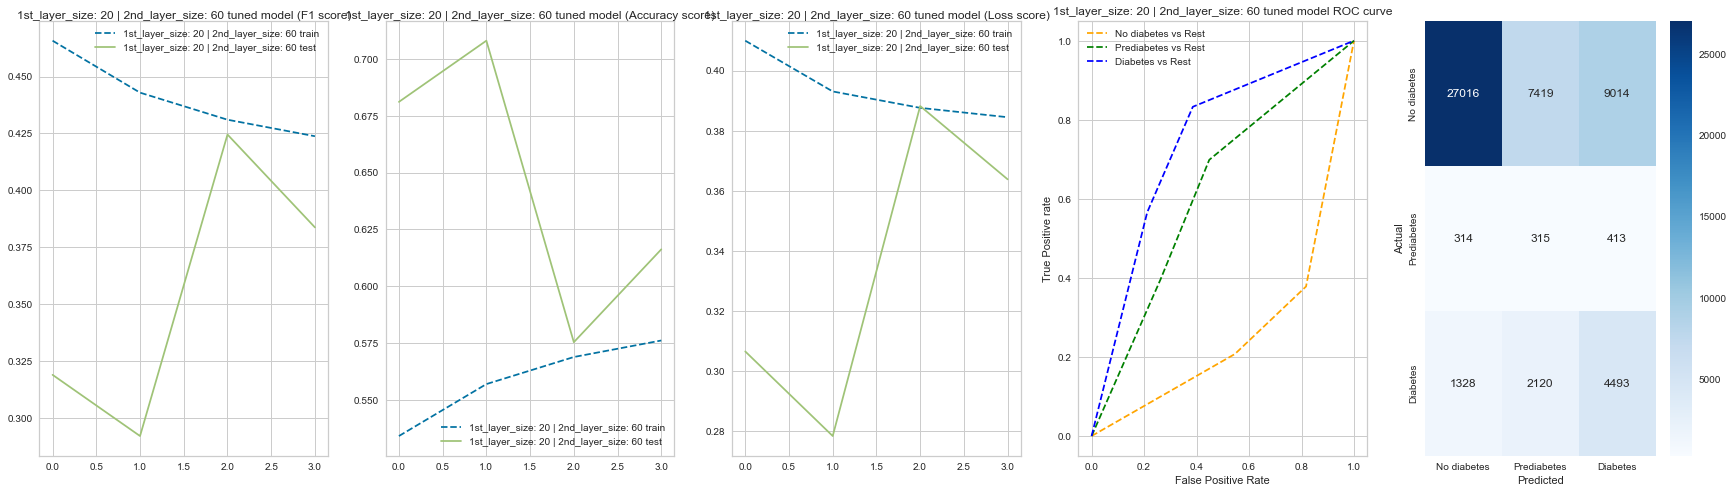

1st_layer_size: 40 | 2nd_layer_size: 20 tuned model


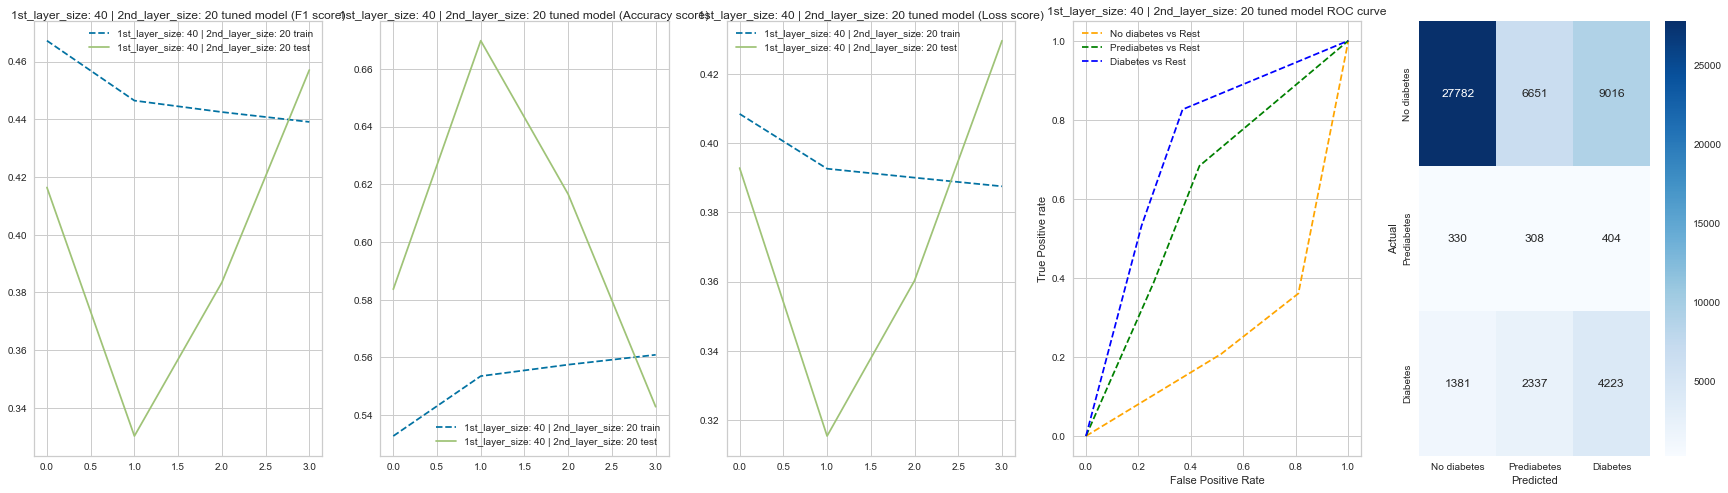

1st_layer_size: 40 | 2nd_layer_size: 40 tuned model


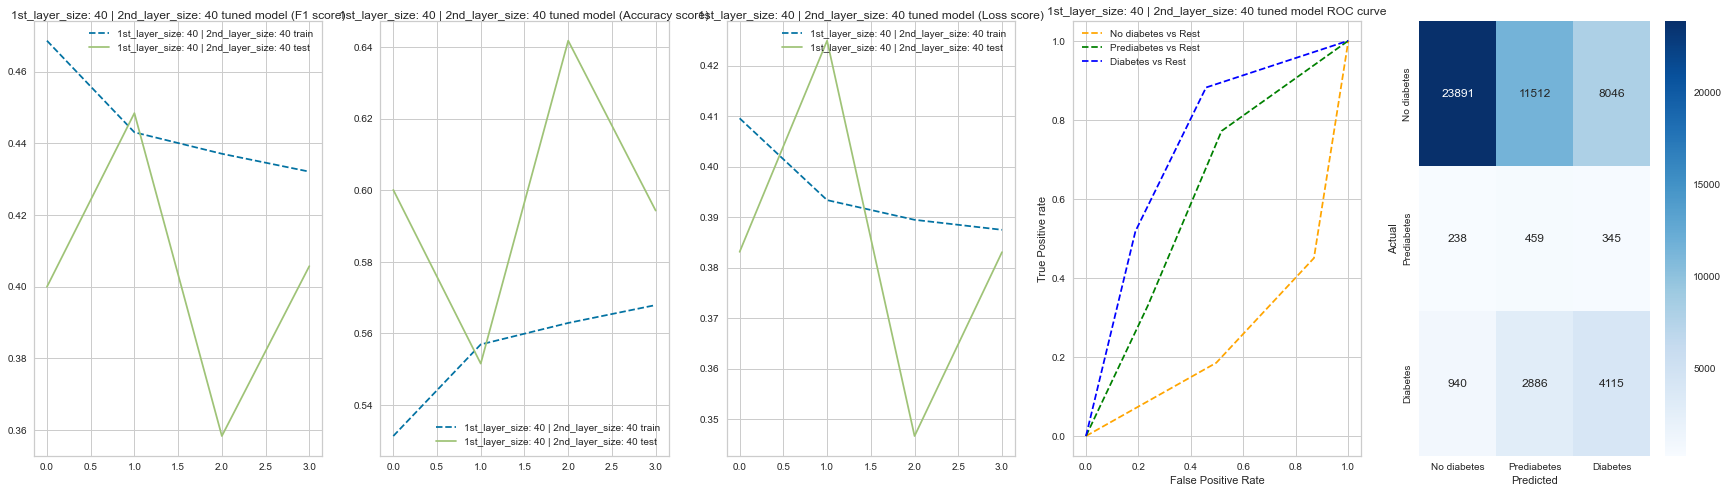

1st_layer_size: 40 | 2nd_layer_size: 60 tuned model


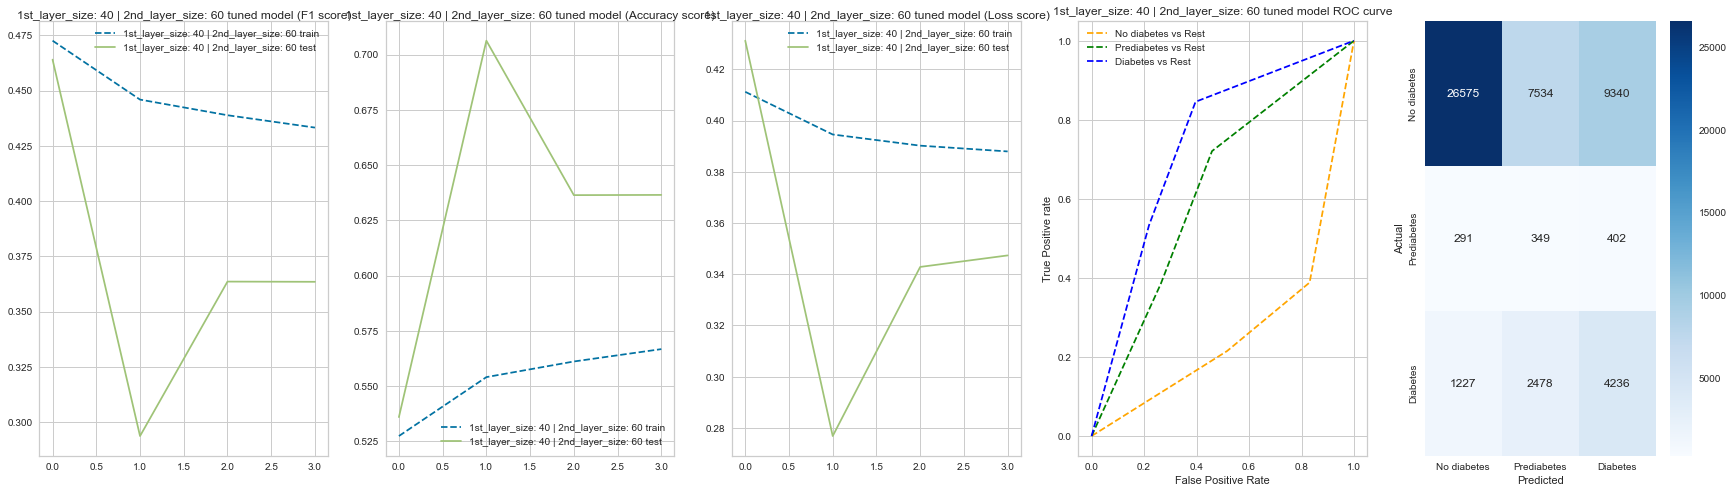

1st_layer_size: 60 | 2nd_layer_size: 20 tuned model


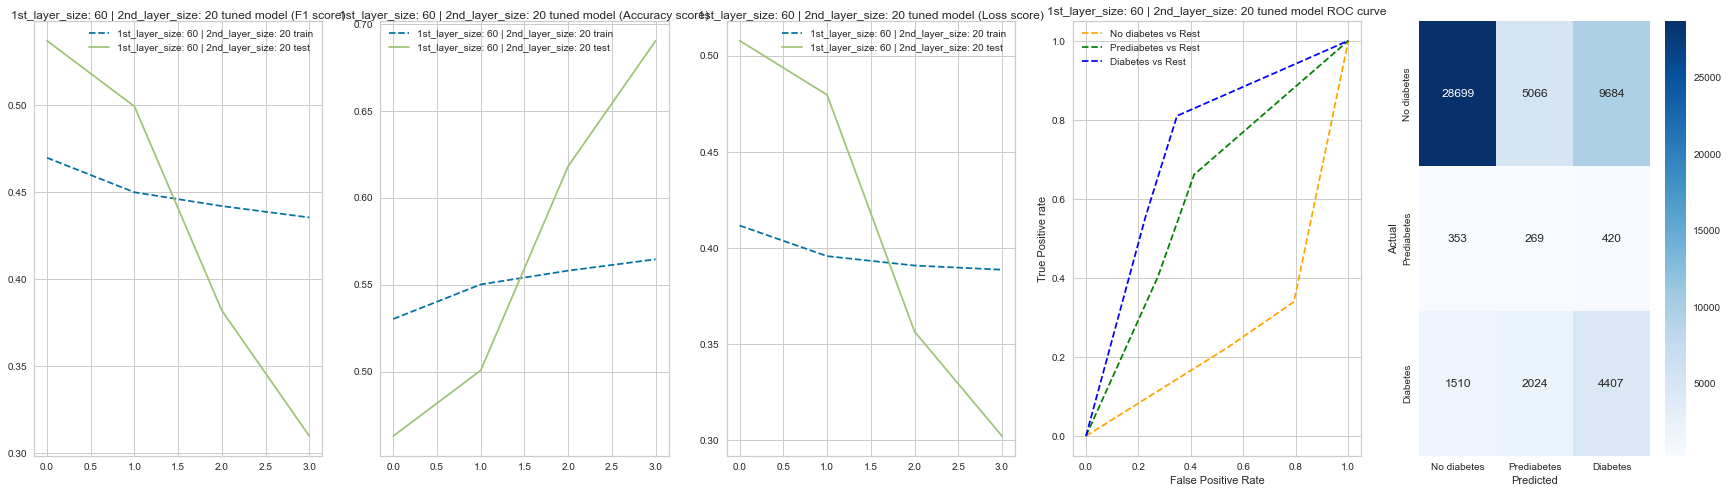

1st_layer_size: 60 | 2nd_layer_size: 40 tuned model


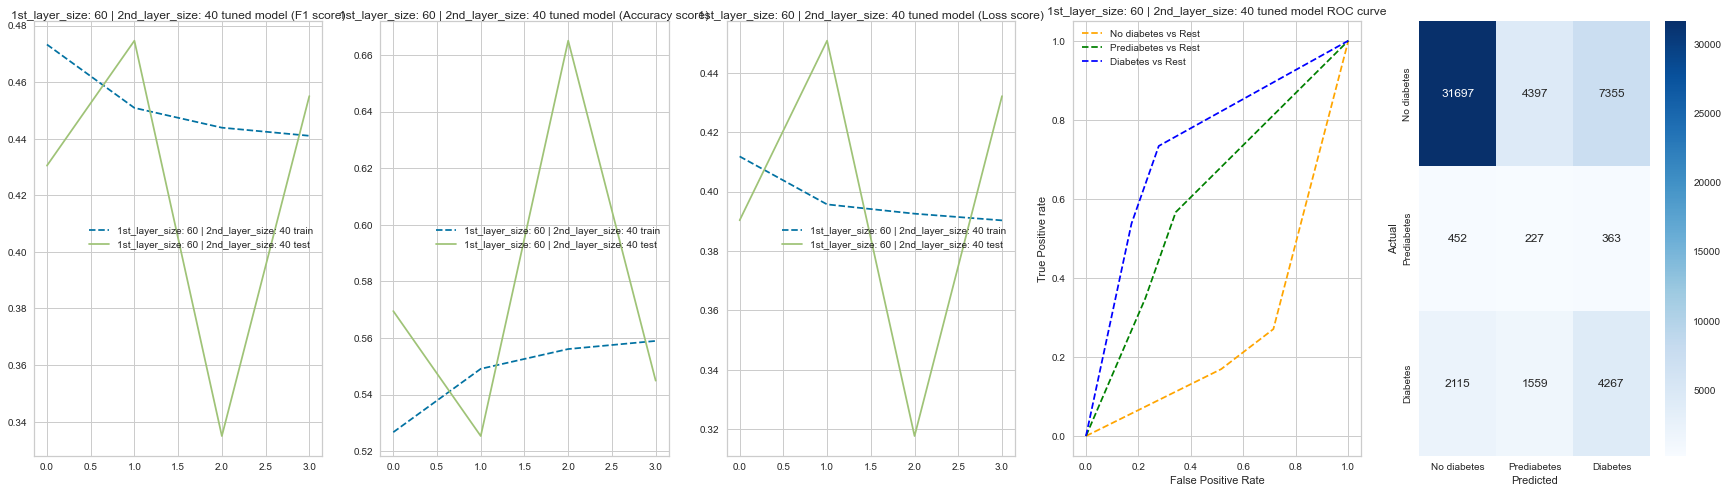

1st_layer_size: 60 | 2nd_layer_size: 60 tuned model


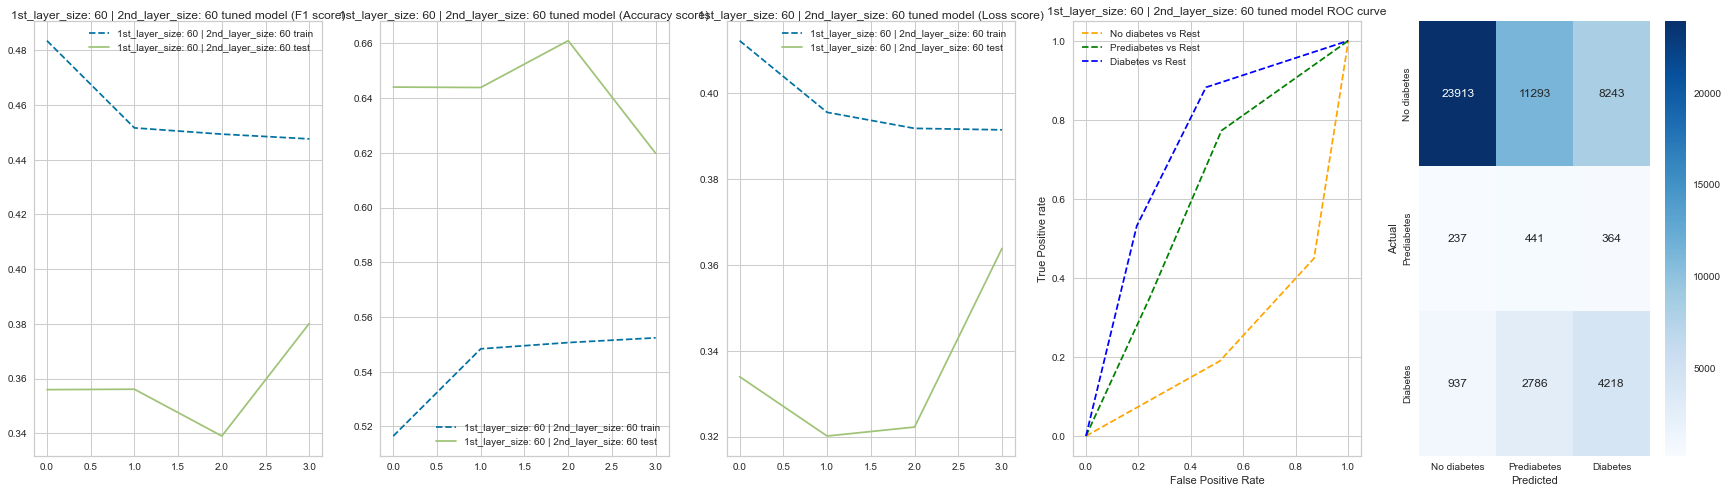

In [ ]:
unit1 = [20, 40, 60]
unit2 = [20, 40, 60]
for i in range(len(unit1)):
    for j in range(len(unit2)):
        res = model_tune(
        unit1=unit1[i],
        unit2=unit2[j],
        epochs=4,
        v_batch=1,
        batch=1,
        gamma=None,
        alpha=None,
        label=f"1st_layer_size: {unit1[i]} | 2nd_layer_size: {unit2[j]}",
        title=f"1st_layer_size: {unit1[i]} | 2nd_layer_size: {unit2[j]} tuned model",
        weight = None,
        n_hidden=2
        )

The result of f1 will depend on

--------------------------------------------------------------------

1st_layer_size: 10 tuned model


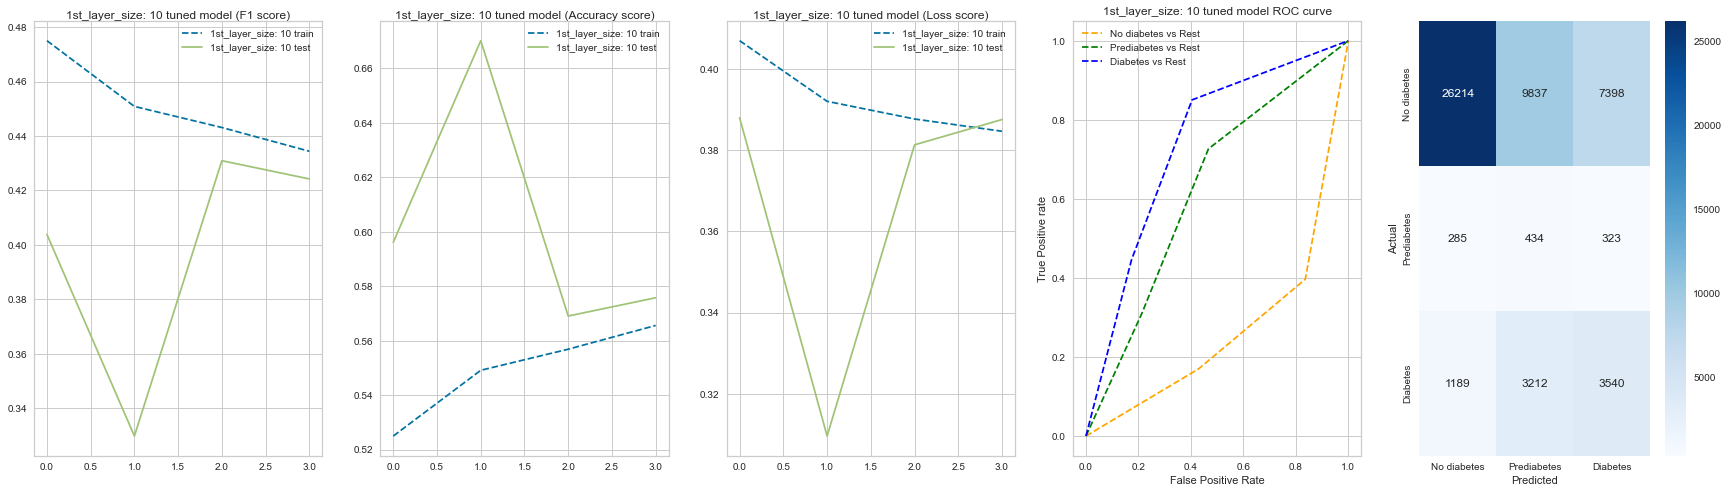

1st_layer_size: 20 tuned model


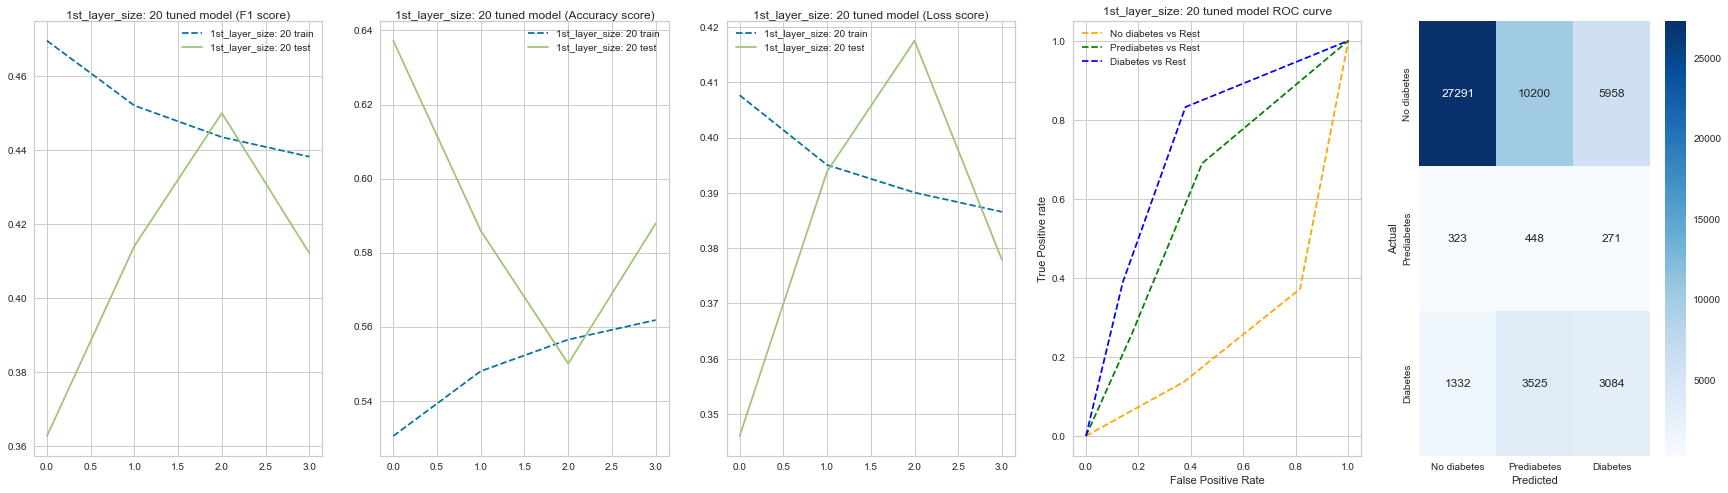

1st_layer_size: 30 tuned model


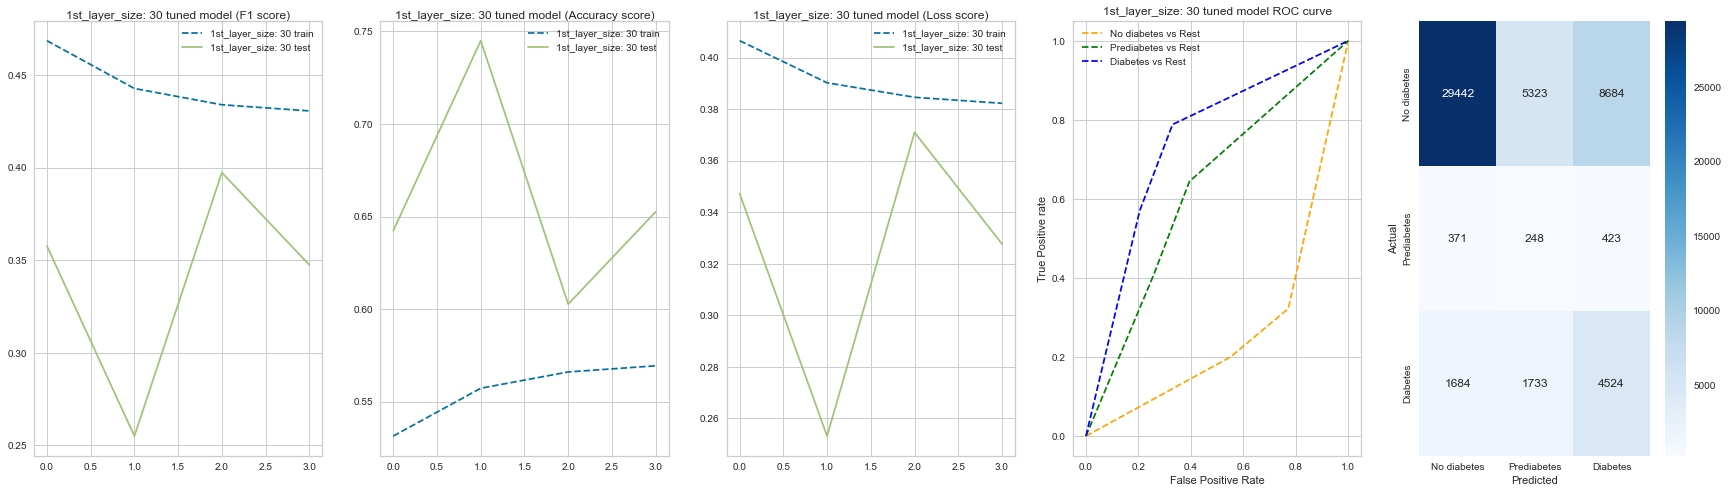

1st_layer_size: 40 tuned model


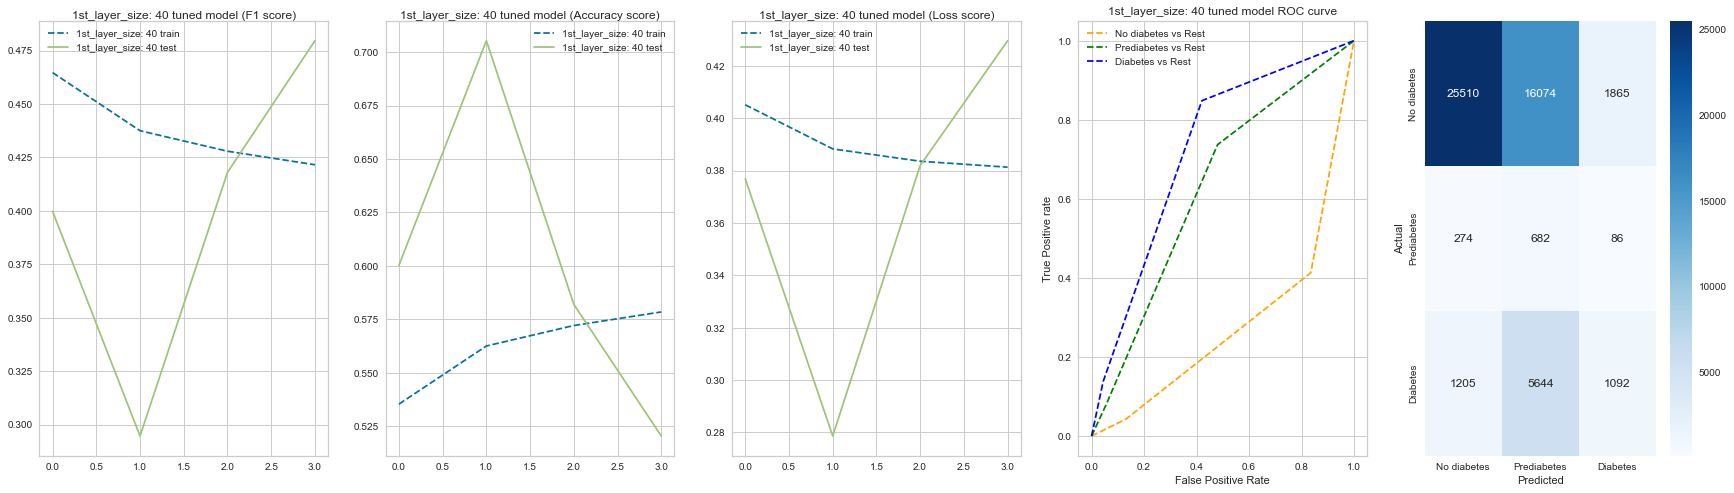

1st_layer_size: 50 tuned model


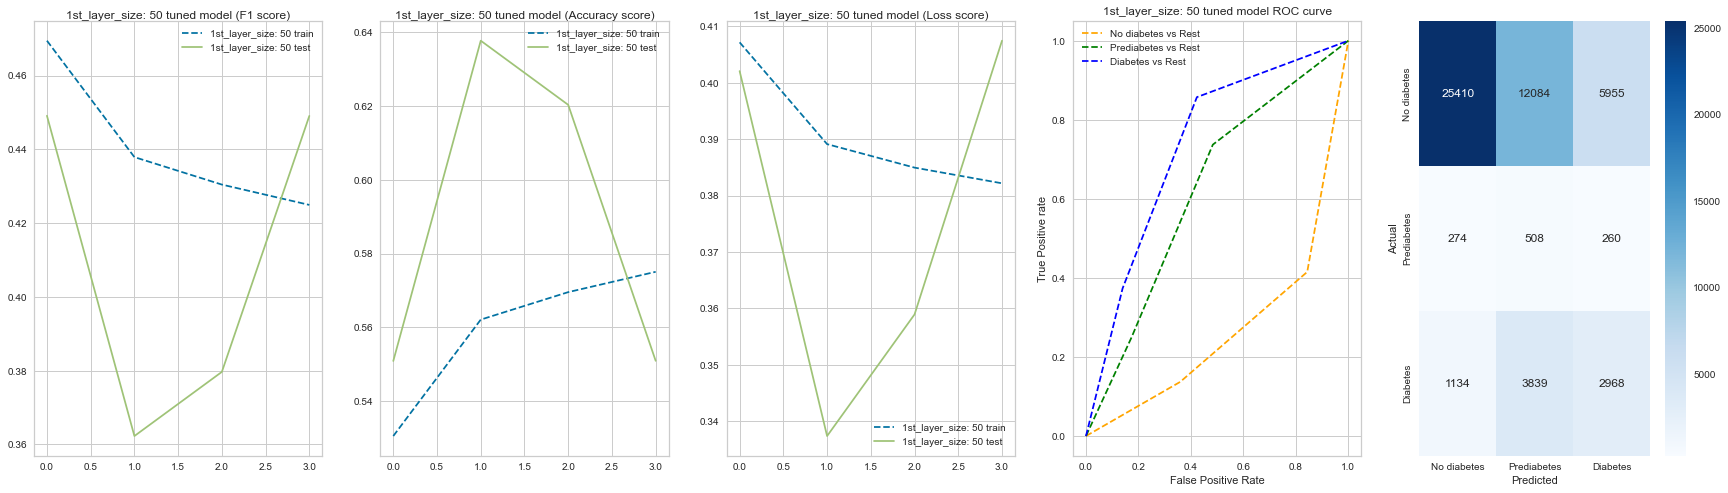

1st_layer_size: 60 tuned model


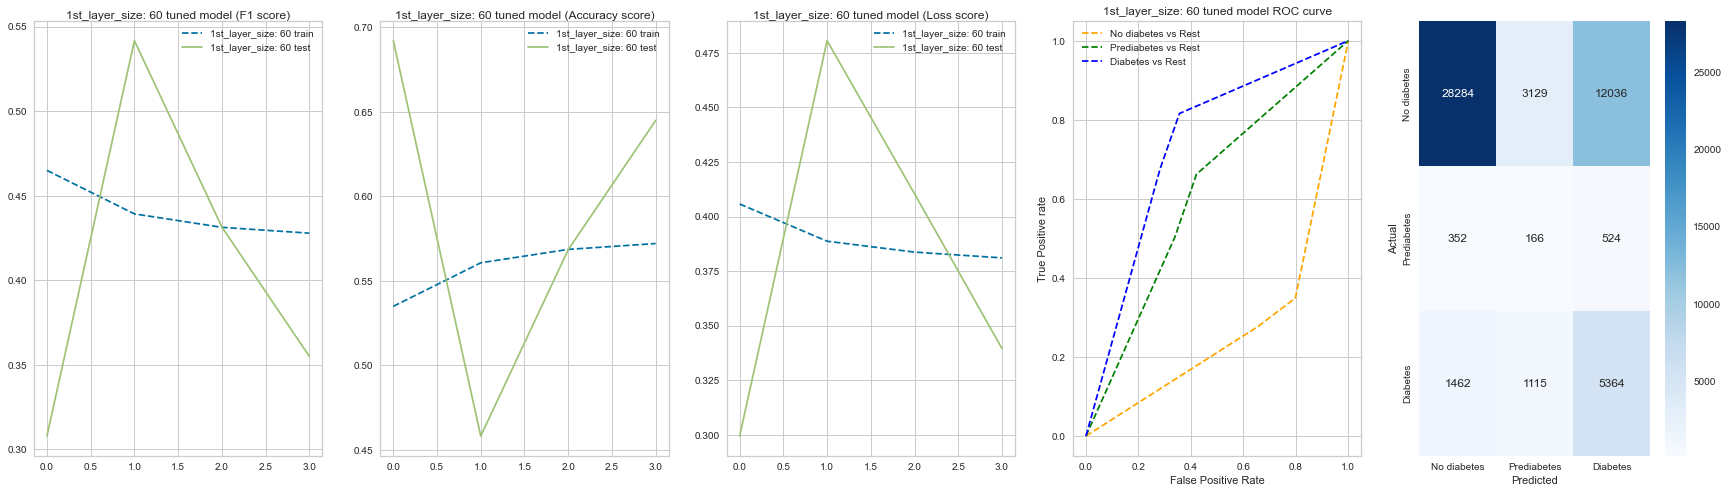

In [ ]:
unit1 = [i for i in range(10, 61, 10)]
for i in range(len(unit1)):
    res = model_tune(
        unit1=unit1[i],
        unit2=None,
        epochs=4,
        v_batch=1,
        batch=1,
        gamma=None,
        alpha=None,
        label=f"1st_layer_size: {unit1[i]}",
        title=f"1st_layer_size: {unit1[i]} tuned model",
        weight = None,
        n_hidden=1
        )

Hypertuned model


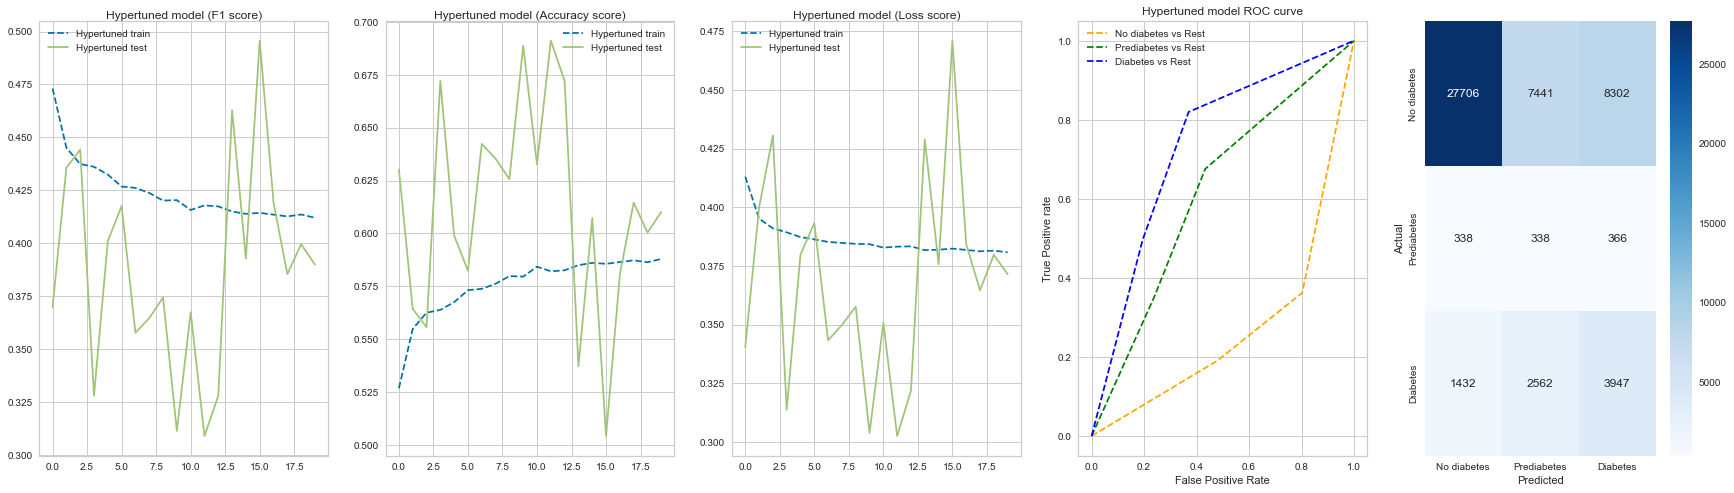

In [ ]:
res = model_tune(
    unit1=60,
    unit2=40,
    epochs=20,
    v_batch=1,
    batch=1,
    gamma=None,
    alpha=None,
    label=f"Hypertuned",
    title=f"Hypertuned model",
    weight = None,
    n_hidden=2
)

## Comparing default with hypertuned neural network

Default neural network validation


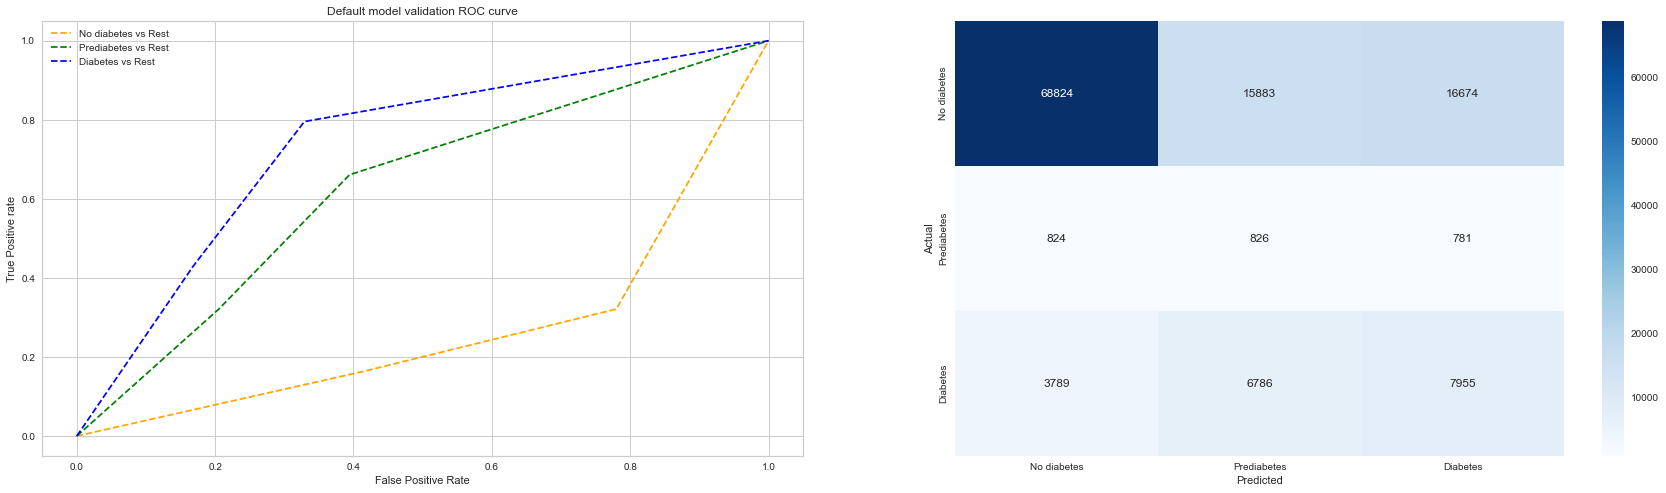

F1 weighted score:  0.7085840453143905


In [ ]:
print("Default neural network validation")

# Plot results
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(30, 8))

y_pred = default_nn.predict(X_val)

fpr, tpr, thresh, n_class = {}, {}, {}, 3

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), pos_label=i)

# plotting
ax[0].plot(fpr[0], tpr[0], linestyle='--',color='orange', label='No diabetes vs Rest')
ax[0].plot(fpr[1], tpr[1], linestyle='--',color='green', label='Prediabetes vs Rest')
ax[0].plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Diabetes vs Rest')
ax[0].set_title(f'Default model validation ROC curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive rate')
ax[0].legend(loc='best')

# Confusion matrix
conf_mat = tf.math.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap = plt.cm.Blues,
        xticklabels=["No diabetes", "Prediabetes", "Diabetes"], yticklabels=["No diabetes", "Prediabetes", "Diabetes"])
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.show()

print("F1 weighted score: ", f1_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), average='weighted'))

Hypertuned neural network validation


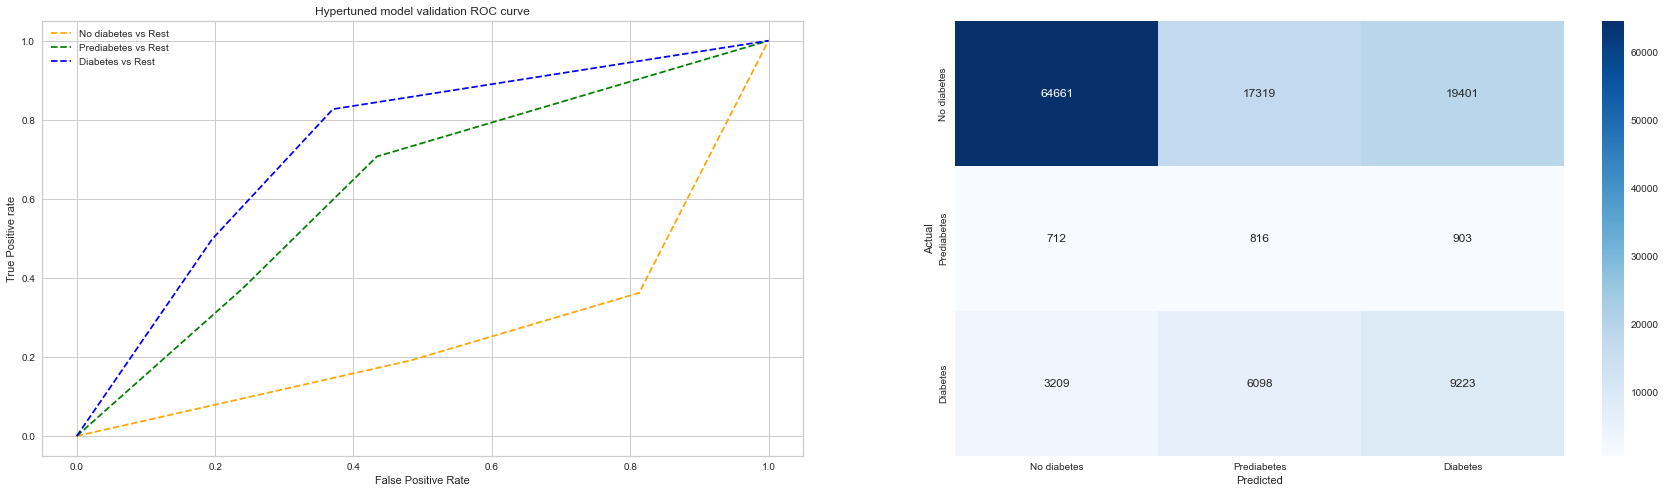

F1 weighted score:  0.6898724515707741


In [ ]:
print("Hypertuned neural network validation")

# Plot results
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(30, 8))

y_pred = res.predict(X_val)

fpr, tpr, thresh, n_class = {}, {}, {}, 3

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), pos_label=i)

# plotting
ax[0].plot(fpr[0], tpr[0], linestyle='--',color='orange', label='No diabetes vs Rest')
ax[0].plot(fpr[1], tpr[1], linestyle='--',color='green', label='Prediabetes vs Rest')
ax[0].plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Diabetes vs Rest')
ax[0].set_title(f'Hypertuned model validation ROC curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive rate')
ax[0].legend(loc='best')

# Confusion matrix
conf_mat = tf.math.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap = plt.cm.Blues,
        xticklabels=["No diabetes", "Prediabetes", "Diabetes"], yticklabels=["No diabetes", "Prediabetes", "Diabetes"])
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.show()

print("F1 weighted score: ", f1_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), average='weighted'))